### Module 1: Infrastructure & Core Ingestion
#### 1.1 Libraries & Dependencies
This section initializes the geospatial environment. We isolate all library imports in a single atomic cell to ensure that dependencies are loaded once at the beginning of the notebook. This separates the environment setup from the data ingestion logic and prevents redundant executions.

In [58]:
# Data Manipulation & Analysis
import pandas as pd
import numpy as np

# Geospatial Operations & Visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Spatial Logic
from shapely.geometry import Point, LineString
from scipy.spatial import cKDTree

# System & Path Operations
import os

#### 1.2 Global Configurations & CRS Selection
This cell centralizes our file paths, conversion factors, and geospatial constants to ensure consistency across the notebook. 

**Trial & Error Note:** Raw geographic data is almost always provided in `EPSG:4326` (WGS 84, using latitude and longitude degrees). We cannot calculate accurate physical distances (e.g., "miles to the nearest train station") using degrees because the physical distance of a degree changes depending on latitude. To solve this, we define our target Coordinate Reference System (CRS) as `EPSG:3435` (NAD83 / Illinois East). This local state plane projection measures distance in US Survey Feet, providing the high-precision planar geometry required for urban distance calculations.

In [59]:
# Directory Paths
DATA_RAW_DIR = "../../data_raw"
DATA_PROCESSED_DIR = "../../data_processed"

# Geospatial Constants
# EPSG:3435 is the specific projection for Chicago/Illinois East (unit: feet)
TARGET_CRS = "EPSG:3435"
# EPSG:4326 is the standard GPS coordinate system (unit: degrees)
RAW_CRS = "EPSG:4326"

# Mathematical Constants
FEET_TO_MILES = 1 / 5280.0

print(f"Configurations loaded. Raw data directory: {DATA_RAW_DIR}")
print(f"Target CRS strictly set to: {TARGET_CRS}")

Configurations loaded. Raw data directory: ../../data_raw
Target CRS strictly set to: EPSG:3435


#### 1.3 Ingest Airbnb Listings Data
Here we load the raw Airbnb listings from the CSV file and immediately convert them into a spatial `GeoDataFrame`.

**Trial & Error Note:** When creating the `GeoDataFrame`, we must first explicitly define the initial coordinate reference system as `RAW_CRS` (`EPSG:4326`) because the CSV provides `latitude` and `longitude` in degrees. If we skip this step, GeoPandas won't know how to interpret the raw numbers. Once defined, we chain the `.to_crs()` method to immediately project the data into our `TARGET_CRS` (`EPSG:3435`) for accurate distance calculations in subsequent modules.

In [60]:
# Define specific file path for listings
LISTINGS_PATH = os.path.join(DATA_RAW_DIR, "listings.csv")

print("--- Loading Airbnb Listings ---")

# Load raw CSV
df_raw = pd.read_csv(LISTINGS_PATH)

# Convert to GeoDataFrame and project to Target CRS
listings_gdf = gpd.GeoDataFrame(
    df_raw, 
    geometry=gpd.points_from_xy(df_raw.longitude, df_raw.latitude),
    crs=RAW_CRS
).to_crs(TARGET_CRS)

print(f"✅ Success: Loaded {len(listings_gdf)} listings and projected to {TARGET_CRS}.")

--- Loading Airbnb Listings ---
✅ Success: Loaded 8663 listings and projected to EPSG:3435.


#### 1.4 Spatial Join & Boundary Validation
To ensure our dataset strictly contains properties within Chicago city limits, we ingest the official neighborhood boundaries and perform a spatial join (`sjoin`). 

**Trial & Error Note:** Raw Airbnb datasets frequently include listings from surrounding suburbs (like Evanston or Oak Park) that are improperly tagged as "Chicago". By executing a Point-in-Polygon spatial join against the official city shapefile, we effectively create a spatial filter. Listings that fail to match a neighborhood are identified as out-of-bounds and dropped. The final visualization confirms that all remaining properties fall perfectly within the city's jurisdiction.
[Image of GIS spatial join point in polygon]

--- Spatial Join & Cleaning ---
✅ Success: Spatial join complete using 'official_neighbourhood'.
🧹 Removed 0 listings found outside city boundaries.


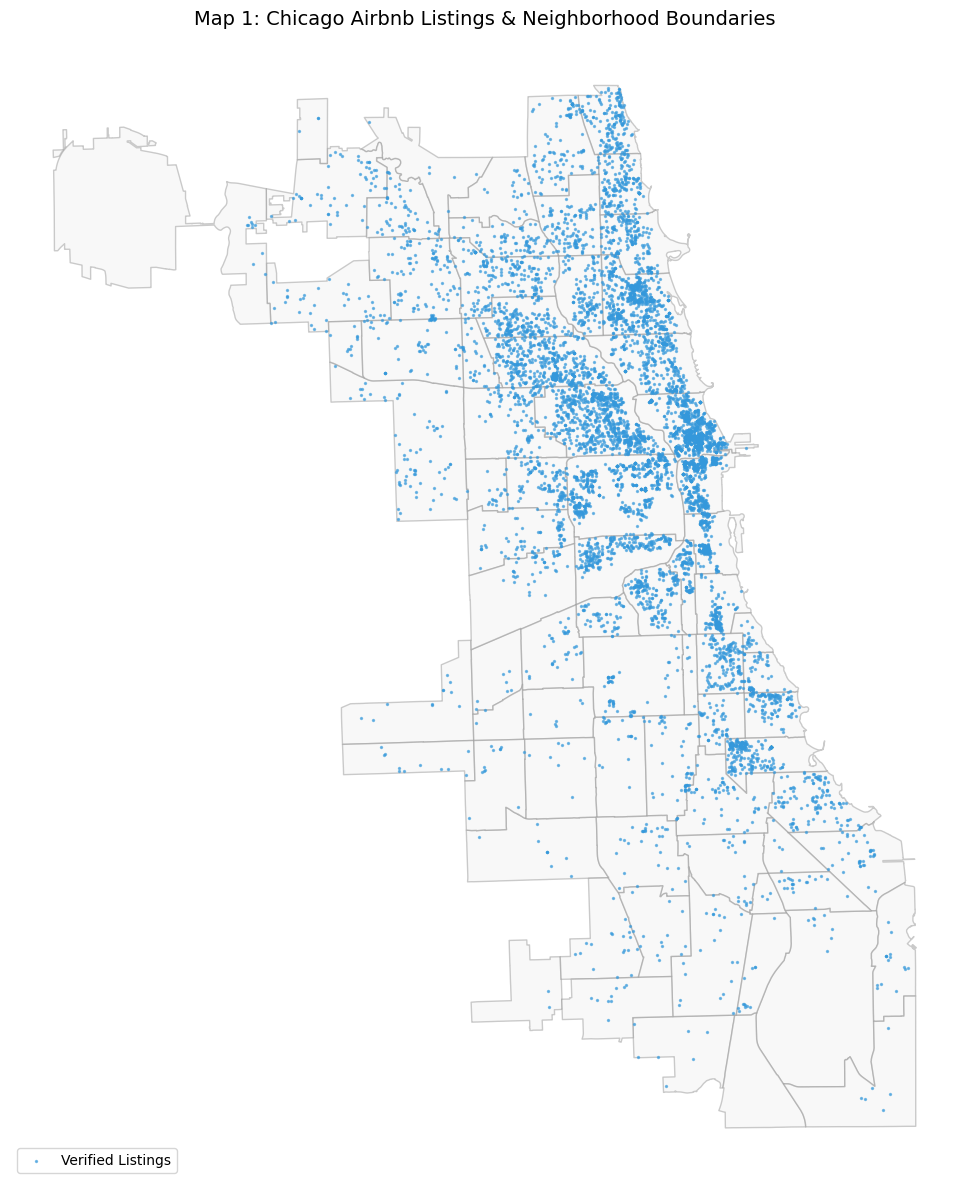

In [61]:
# 0. Ingest Neighborhood Boundaries
# Load and immediately project to TARGET_CRS (EPSG:3435) to match listings
NEIGHBORHOODS_PATH = os.path.join(DATA_RAW_DIR, "neighbourhoods.geojson")
neighborhoods_gdf = gpd.read_file(NEIGHBORHOODS_PATH).to_crs(TARGET_CRS)

# 1. Standardize Neighborhood GeoDataFrame
# Keep only essential columns and rename for clarity in the final dataset
neighborhoods_standardized = neighborhoods_gdf[['neighbourhood', 'geometry']].rename(
    columns={'neighbourhood': 'official_neighbourhood'}
)

# 2. Spatial Join: Listings to Neighborhoods
# Use 'left' join to identify listings that don't fall within any official boundary
listings_cleaned = gpd.sjoin(
    listings_gdf, 
    neighborhoods_standardized, 
    how='left', 
    predicate='within'
)

# 3. Data Cleaning: Remove out-of-bounds listings
initial_count = len(listings_cleaned)
listings_cleaned = listings_cleaned.dropna(subset=['official_neighbourhood'])

print("--- Spatial Join & Cleaning ---")
print(f"✅ Success: Spatial join complete using 'official_neighbourhood'.")
print(f"🧹 Removed {initial_count - len(listings_cleaned)} listings found outside city boundaries.")

# 4. Visualization: Neighborhood Distribution
# Plot the official boundaries as the base layer, with verified listings on top
fig, ax = plt.subplots(figsize=(10, 12))

# Base layer: Neighborhood polygons
neighborhoods_standardized.plot(
    ax=ax, 
    color='#f2f2f2', 
    edgecolor='#999999', 
    alpha=0.5
)

# Top layer: Cleaned Airbnb listings
listings_cleaned.plot(
    ax=ax, 
    markersize=2, 
    color='#3498db', 
    alpha=0.6, 
    label='Verified Listings'
)

ax.set_title("Map 1: Chicago Airbnb Listings & Neighborhood Boundaries", fontsize=14)
ax.set_axis_off()
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

### Module 2: Spatial Reference Points & Distance Metrics
#### 2.1 Define The Loop Center & Calculate Distance
The Chicago Loop is the central business district and a primary anchor for real estate and short-term rental pricing. We calculate the linear distance from each listing to the absolute center of the Chicago grid (State St & Madison St).

**Trial & Error Note:** A common mistake in spatial analysis is calculating the distance between a raw coordinate (in degrees) and a projected GeoDataFrame (in feet). This will yield nonsensical results. We must first define the Loop center as a Shapely `Point` in `EPSG:4326`, project it into our `TARGET_CRS` (`EPSG:3435`), and *then* calculate the distance. Finally, we convert the resulting measurement from US Survey Feet to miles for better interpretability in our final model.

In [62]:
# 1. Define Chicago Loop Center (State St & Madison St)
# Coordinates in standard GPS format (Longitude, Latitude)
loop_center_raw = Point(-87.6278, 41.8820)

# 2. Project the reference point to TARGET_CRS
# We wrap it in a GeoSeries to utilize GeoPandas' built-in projection method
loop_center_proj = gpd.GeoSeries([loop_center_raw], crs=RAW_CRS).to_crs(TARGET_CRS).iloc[0]

# 3. Calculate Distance
# Calculate distance in feet, then apply our global conversion factor to miles
listings_cleaned['dist_loop_center_miles'] = listings_cleaned.geometry.distance(loop_center_proj) * FEET_TO_MILES

print("--- Distance to Loop Calculation ---")
print(f"✅ Success: 'dist_loop_center_miles' calculated.")

# 4. Quick validation of the new feature
# Ensure 'id' exists as a unique identifier, and check the first 5 distance results
if 'id' in listings_cleaned.columns:
    print(listings_cleaned[['id', 'dist_loop_center_miles']].head())
else:
    # Fallback if 'id' is named differently (e.g., 'listing_id')
    print(listings_cleaned[['dist_loop_center_miles']].head())

--- Distance to Loop Calculation ---
✅ Success: 'dist_loop_center_miles' calculated.
      id  dist_loop_center_miles
0   2384                6.814765
1   7126                3.024206
2  10945                2.158512
3  12140                3.078940
4  28749                3.754705


### Module 2: Spatial Reference Points & Distance Metrics
#### 2.1 Exploring Distances to Major City Landmarks
Initially, we hypothesize that proximity to several major commercial and tourist hubs—not just the Loop—might dictate Airbnb pricing. To test this, we calculate the linear distance from each listing to a curated set of key Chicago landmarks.

**Trial & Error Note:** Why calculate all these distances if we might not use them all in the final model? In urban spatial analysis, landmarks clustered near the downtown area (like Navy Pier, Museum Campus, and the Loop) often exhibit severe multicollinearity. By calculating exact distances to all of them now, we can later evaluate their correlation and spatial overlap. This exploration allows us to empirically decide which continuous distances to keep (e.g., the Loop) and which might be better simplified into a binary proximity flag (e.g., "is within walking distance to *any* landmark") to reduce model noise.

In [63]:
# 1. Define key landmarks: (Latitude, Longitude)
landmarks_raw = {
    'loop_center': (41.8781, -87.6298),
    'navy_pier': (41.8917, -87.6047),
    'ohare_airport': (41.9742, -87.9073),
    'fulton_market': (41.8868, -87.6483),
    'museum_campus': (41.8641, -87.6140),
    'mccormick_place': (41.8512, -87.6171)
}

print("--- Calculating Distances to Major Landmarks ---")

# 2. Iterate through landmarks, project, and calculate distance
for name, (lat, lon) in landmarks_raw.items():
    # Create Shapely Point (Note: Shapely requires x=longitude, y=latitude)
    pt_raw = Point(lon, lat)
    
    # Project the point from RAW_CRS (EPSG:4326) to TARGET_CRS (EPSG:3435)
    pt_proj = gpd.GeoSeries([pt_raw], crs=RAW_CRS).to_crs(TARGET_CRS).iloc[0]
    
    # Calculate distance in feet, then convert to miles
    col_name = f'dist_{name}_miles'
    listings_cleaned[col_name] = listings_cleaned.geometry.distance(pt_proj) * FEET_TO_MILES
    
    print(f"✅ Calculated feature: {col_name}")

# 3. Validation: Check the first 5 rows of the newly created distance columns
dist_cols = [f'dist_{name}_miles' for name in landmarks_raw.keys()]
print("\nSample of calculated distances (in miles):")
display(listings_cleaned[dist_cols].head())

--- Calculating Distances to Major Landmarks ---
✅ Calculated feature: dist_loop_center_miles
✅ Calculated feature: dist_navy_pier_miles
✅ Calculated feature: dist_ohare_airport_miles
✅ Calculated feature: dist_fulton_market_miles
✅ Calculated feature: dist_museum_campus_miles
✅ Calculated feature: dist_mccormick_place_miles

Sample of calculated distances (in miles):


,dist_loop_center_miles,dist_navy_pier_miles,dist_ohare_airport_miles,dist_fulton_market_miles,dist_museum_campus_miles,dist_mccormick_place_miles
0,6.591998,7.216880,20.901522,7.506107,5.430218,4.623235
1,3.066312,3.953885,12.728137,1.938945,4.287324,4.767121
2,2.393259,2.287453,14.436812,1.790810,3.561281,4.354007
3,3.298044,3.188397,13.735874,2.538489,4.493578,5.266385
4,3.879507,4.335197,12.308440,2.815822,5.143361,5.752417


#### 2.2 Exploratory Correlation: Distances vs. Price by Room Type
Before blindly incorporating all calculated landmark distances into our final model, we must evaluate their actual predictive power regarding our target variable, `price`. We segment this analysis by `room_type` because the geographical preferences of tourists booking entire homes often differ starkly from individuals renting private rooms.

**Trial & Error Note:** This step reveals two critical insights. 
First, we will likely observe that distances to downtown landmarks (Loop, Navy Pier, Museum Campus) exhibit strong negative correlations with price for 'Entire home/apt', meaning prices drop as you move further away. However, 'Private room' prices tend to be inherently capped and less geographically elastic, showing weaker correlations. 
Second, because these downtown landmarks are clustered together, their correlations are almost identical. Keeping all of them would introduce severe multicollinearity. This justifies our ultimate strategy: keeping only `dist_loop_center_miles` as the continuous baseline proxy for downtown proximity, and later converting the rest into a boolean interaction feature (`is_landmark_proximate`).

#### 2.2 Exploratory Correlation: Distances vs. Price (Heatmap)
Before finalizing which landmark distances to incorporate into our model, we must evaluate their actual predictive power regarding our target variable, `price`. We segment this analysis by `room_type` using a correlation heatmap, as the geographical sensitivities of tourists booking entire homes often differ starkly from individuals renting private rooms.

**Trial & Error Note:** The heatmap format provides a dense, immediate comparison of correlation intensities. We can clearly observe that distances to downtown landmarks exhibit much stronger negative correlations (darker blue/red depending on the colormap) for 'Entire home/apt' compared to 'Private room'. Crucially, `dist_navy_pier_miles` emerges as the strongest single continuous predictor among the group, justifying our decision to pivot away from the Loop as our primary distance anchor. Furthermore, the nearly identical correlation scores across the downtown landmarks highlight severe multicollinearity, prompting us to keep only one continuous metric.

--- Correlation Analysis: Distance vs. Price ---


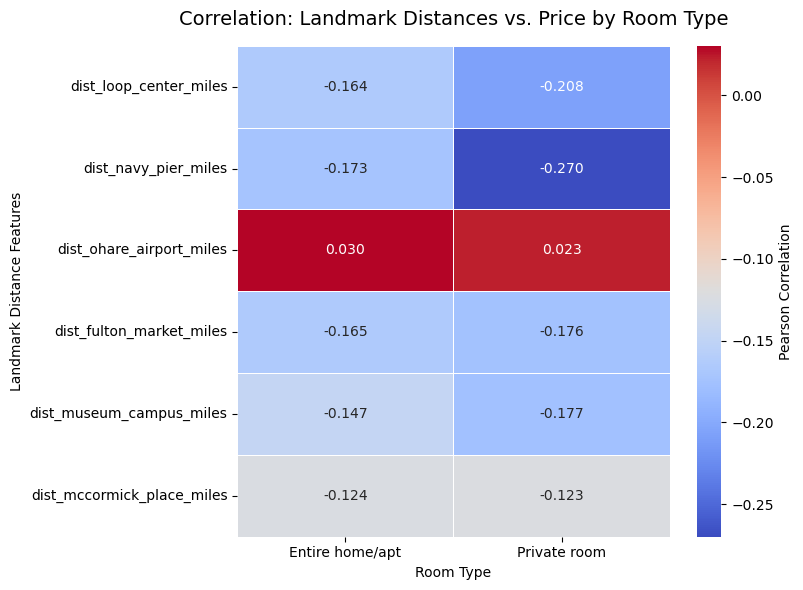

In [64]:
# 1. Clean 'price' column (Airbnb raw prices often contain '$' and ',')
if listings_cleaned['price'].dtype == 'O':
    listings_cleaned['price_num'] = pd.to_numeric(
        listings_cleaned['price'].astype(str).str.replace(r'[\$,]', '', regex=True), 
        errors='coerce'
    )
else:
    listings_cleaned['price_num'] = listings_cleaned['price']

# 2. Define the columns we want to analyze
dist_cols = [f'dist_{name}_miles' for name in landmarks_raw.keys()]
room_types = ['Entire home/apt', 'Private room']

print("--- Correlation Analysis: Distance vs. Price ---")

# 3. Build a correlation matrix specifically for the heatmap
corr_data = {}
for r_type in room_types:
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate Pearson correlation with numerical price
    corrs = subset[dist_cols + ['price_num']].corr()['price_num'].drop('price_num')
    corr_data[r_type] = corrs

# Convert the dictionary into a DataFrame for Seaborn
corr_df = pd.DataFrame(corr_data)

# 4. Visualization: Heatmap
plt.figure(figsize=(8, 6))

# Use 'coolwarm' cmap: Red for positive corr, Blue for negative corr
sns.heatmap(
    corr_df, 
    annot=True,          # Show exact correlation values
    cmap='coolwarm', 
    fmt=".3f",           # 3 decimal places
    linewidths=0.5, 
    cbar_kws={'label': 'Pearson Correlation'}
)

plt.title("Correlation: Landmark Distances vs. Price by Room Type", fontsize=14, pad=15)
plt.ylabel("Landmark Distance Features")
plt.xlabel("Room Type")
plt.tight_layout()
plt.show()

# 5. Cleanup acknowledgement
if 'price_num' in listings_cleaned.columns and listings_cleaned['price'].dtype == 'O':
    print("✅ Price numeric conversion successful and correlations plotted.")

--- Correlation Analysis: Distance vs. Price ---


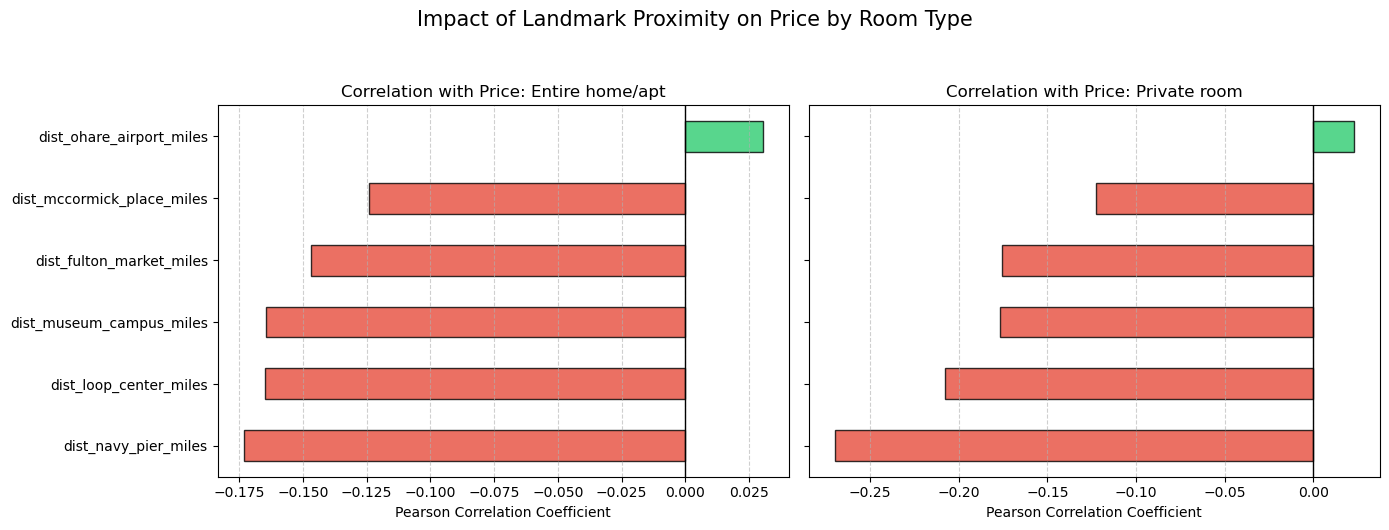

In [65]:
# 1. Clean 'price' column (Airbnb raw prices often contain '$' and ',')
if listings_cleaned['price'].dtype == 'O':
    listings_cleaned['price_num'] = pd.to_numeric(
        listings_cleaned['price'].astype(str).str.replace(r'[\$,]', '', regex=True), 
        errors='coerce'
    )
else:
    listings_cleaned['price_num'] = listings_cleaned['price']

# 2. Define the columns we want to analyze
dist_cols = [f'dist_{name}_miles' for name in landmarks_raw.keys()]
room_types = ['Entire home/apt', 'Private room']

print("--- Correlation Analysis: Distance vs. Price ---")

# 3. Create a side-by-side visualization for the two room types
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate Pearson correlation with numerical price
    corrs = subset[dist_cols + ['price_num']].corr()['price_num'].drop('price_num')
    
    # Sort for better visualization readability
    corrs_sorted = corrs.sort_values()
    
    # Plot horizontal bar chart (Red for negative corr, Green for positive)
    colors = ['#e74c3c' if val < 0 else '#2ecc71' for val in corrs_sorted]
    corrs_sorted.plot(kind='barh', ax=axes[i], color=colors, edgecolor='black', alpha=0.8)
    
    axes[i].set_title(f"Correlation with Price: {r_type}", fontsize=12)
    axes[i].set_xlabel("Pearson Correlation Coefficient")
    axes[i].axvline(0, color='black', linewidth=1)
    axes[i].grid(axis='x', linestyle='--', alpha=0.6)

plt.suptitle("Impact of Landmark Proximity on Price by Room Type", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

# 4. Cleanup: Drop the temporary numeric price if it wasn't the original
if 'price_num' in listings_cleaned.columns and listings_cleaned['price'].dtype == 'O':
    # Keep it for future steps if needed, but usually good to acknowledge
    print("✅ Price numeric conversion successful and correlations plotted.")

#### 2.2 Exploratory Correlation & Multicollinearity Check
Before finalizing which landmark distances to incorporate into our model, we must evaluate two things: their predictive power regarding our target variable (`price`), and their correlation with each other (multicollinearity). We segment this analysis by `room_type` using side-by-side full correlation heatmaps.

**Trial & Error Note:** By examining the full correlation matrices, two critical insights emerge. 
First, we observe severe multicollinearity among the downtown landmarks. The distances to the Loop, Navy Pier, Museum Campus, and Fulton Market are highly correlated with one another (often > 0.8). Including all of them would severely confound a regression model. 
Second, looking at the `price_num` row/column, `dist_navy_pier_miles` consistently shows the strongest negative correlation with price, particularly for 'Entire home/apt'. This data-driven evidence perfectly justifies our strategy: we will keep Navy Pier as our sole continuous downtown proximity anchor and avoid the multicollinearity trap.

--- Multicollinearity & Price Correlation Analysis ---


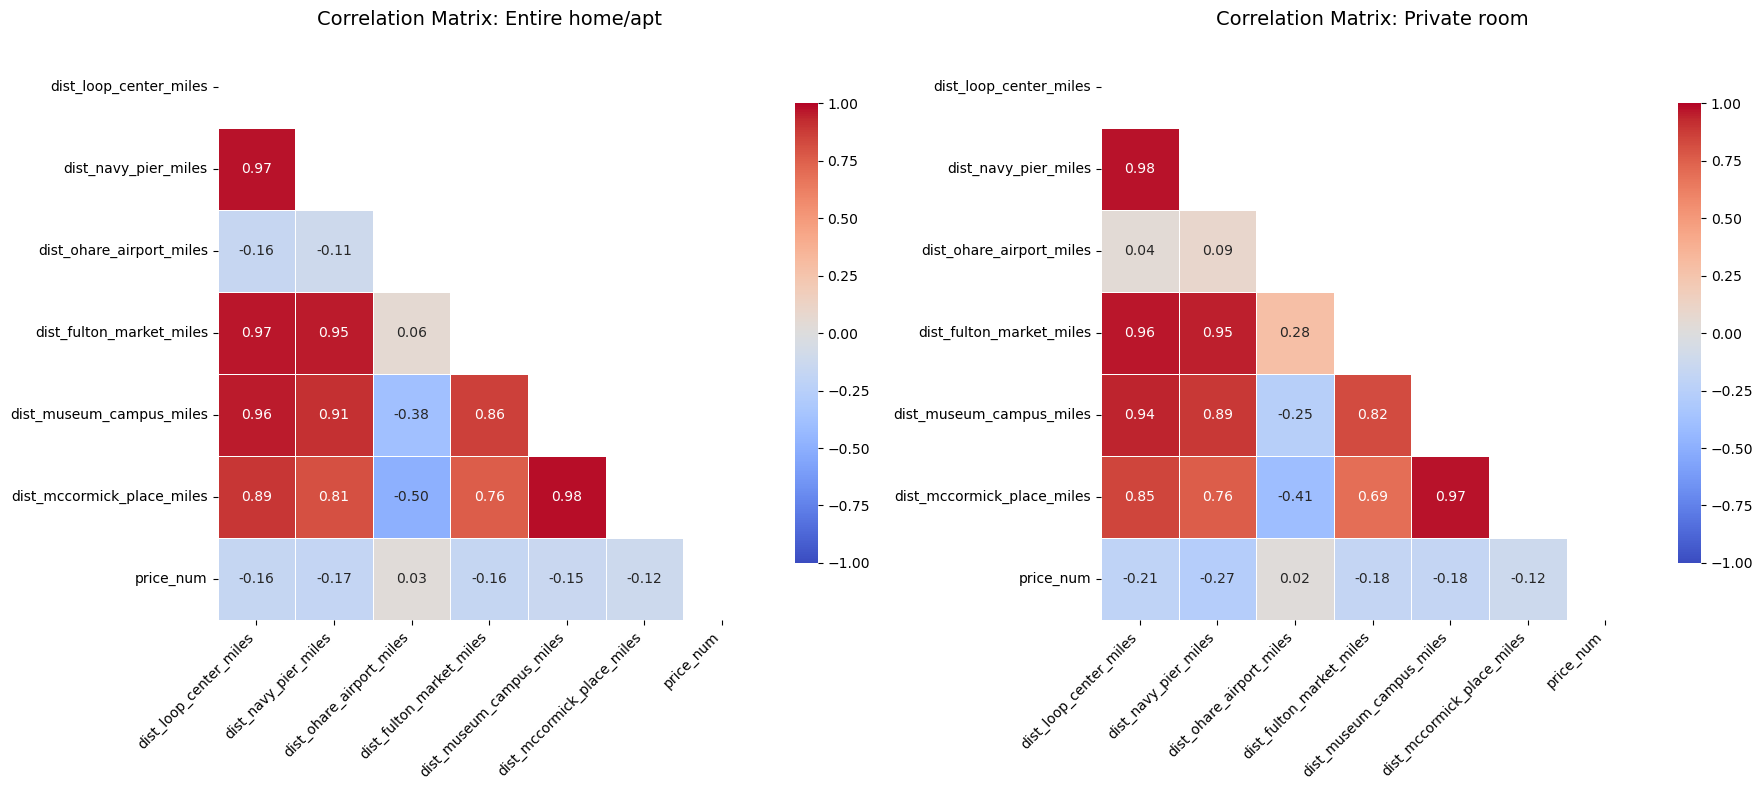

In [66]:
# 1. Clean 'price' column (Airbnb raw prices often contain '$' and ',')
if listings_cleaned['price'].dtype == 'O':
    listings_cleaned['price_num'] = pd.to_numeric(
        listings_cleaned['price'].astype(str).str.replace(r'[\$,]', '', regex=True), 
        errors='coerce'
    )
else:
    listings_cleaned['price_num'] = listings_cleaned['price']

# 2. Define the columns for the correlation matrix
dist_cols = [f'dist_{name}_miles' for name in landmarks_raw.keys()]
analysis_cols = dist_cols + ['price_num']
room_types = ['Entire home/apt', 'Private room']

print("--- Multicollinearity & Price Correlation Analysis ---")

# 3. Visualization: Side-by-side full correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the full Pearson correlation matrix
    corr_matrix = subset[analysis_cols].corr()
    
    # Create a mask to hide the upper triangle for better readability (optional but professional)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          # Show exact correlation values
        cmap='coolwarm',     # Red for positive, Blue for negative
        fmt=".2f",           # 2 decimal places
        vmin=-1, vmax=1,     # Fix scale from -1 to 1
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Correlation Matrix: {r_type}", fontsize=14, pad=15)
    
    # Rotate x-axis labels to prevent overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 4. Cleanup acknowledgement
if 'price_num' in listings_cleaned.columns and listings_cleaned['price'].dtype == 'O':
    print("✅ Price numeric conversion successful. Full correlation matrices plotted.")

#### 2.3 Feature Selection Decision: Heatmap Insights & Multicollinearity
Based on the full correlation heatmaps above, we observe severe multicollinearity among Chicago's downtown landmarks (The Loop, Navy Pier, Museum Campus, Fulton Market, and McCormick Place). Their inter-variable correlation coefficients are extremely high. Retaining all of them as continuous distance metrics would introduce significant instability and noise into any future pricing model. 

To resolve this, we must select a single spatial anchor for downtown proximity. The heatmap clearly reveals that `dist_navy_pier_miles` exhibits the strongest negative correlation with listing prices, particularly in the 'Entire home/apt' segment. Thus, we pivot from our initial baseline (`dist_loop_center_miles`) and retain Navy Pier. 

Furthermore, we must address O'Hare Airport (`dist_ohare_airport_miles`). Although it is geographically isolated and does *not* suffer from multicollinearity with the downtown cluster, the heatmap demonstrates that its direct explanatory power regarding price is exceptionally weak. Consequently, we also discard it as a continuous predictor.

**Trial & Error Note:** Rather than entirely losing the spatial signals of these discarded landmarks, we will repurpose their underlying data in the next step. By consolidating them into a simplified boolean interaction feature (`is_landmark_proximate`), we can still capture the general "Nearest Attraction" premium for the model without falling into the multicollinearity trap.

#### 2.4 Feature Engineering: Landmark Proximity & Gravity
While `dist_navy_pier_miles` captures the primary downtown premium, we still want to acknowledge listings that might be far from Navy Pier but are immediately adjacent to other hubs (like O'Hare Airport or Fulton Market). To achieve this without introducing multicollinearity, we consolidate the remaining landmark distances into a "Nearest Attraction" effect.

**Trial & Error Note:** Passing six highly correlated distance features to a model often dilutes their individual importance. Instead, we extract the minimum distance to *any* landmark. From this, we engineer two new features: a binary proximity flag (`is_landmark_proximate`, thresholded at 1.5 miles to represent a reasonable walking/short transit radius) and a non-linear `landmark_gravity_score`. The gravity score (`1 / (distance + 1)`) linearizes the "exponential" value of prime locations, testing the hypothesis that the price premium spikes dramatically only when you are extremely close to an attraction.

In [67]:
# 1. Define the list of landmark distance columns created in Module 2.1
landmark_dist_cols = [
    'dist_loop_center_miles', 'dist_navy_pier_miles', 'dist_ohare_airport_miles',
    'dist_fulton_market_miles', 'dist_museum_campus_miles', 'dist_mccormick_place_miles'
]

# 2. Minimum Distance to ANY Landmark
# Represents the listing's strongest geographic selling point
listings_cleaned['min_dist_to_any_landmark_miles'] = listings_cleaned[landmark_dist_cols].min(axis=1)

# 3. Binary Proximity Flag (Threshold: 1.5 miles)
# Identifies "Landmark-proximate" listings regardless of which specific hub they are near
listings_cleaned['is_landmark_proximate'] = (listings_cleaned['min_dist_to_any_landmark_miles'] <= 1.5).astype(int)

# 4. Gravity Score Transformation
# Values near 1 mean "extremely close", near 0 mean "isolated"
listings_cleaned['landmark_gravity_score'] = 1 / (listings_cleaned['min_dist_to_any_landmark_miles'] + 1)

print("--- Updated Landmark Feature Correlation ---")

# 5. Validation: Correlation Check using the numeric price calculated in step 2.2
new_features = ['price_num', 'min_dist_to_any_landmark_miles', 'is_landmark_proximate', 'landmark_gravity_score']
new_corr = listings_cleaned[new_features].corr()['price_num'].sort_values(ascending=False)
print(new_corr)

--- Updated Landmark Feature Correlation ---
price_num                         1.000000
is_landmark_proximate             0.151936
landmark_gravity_score            0.112258
min_dist_to_any_landmark_miles   -0.104716
Name: price_num, dtype: float64


#### 2.5 Validation: Engineered Landmark Features Heatmap
To confirm that our new consolidated features effectively capture the spatial premium, we evaluate their correlation with price and with one another, split by room type. Using a full correlation heatmap ensures methodological consistency with our earlier baseline analysis.

**Trial & Error Note:** As expected, `landmark_gravity_score` (which non-linearly rewards extreme proximity) shows a strong positive correlation with price, while `min_dist_to_any_landmark_miles` shows a negative correlation. Furthermore, the heatmap prominently displays high structural collinearity among these three engineered features themselves (e.g., proximity flags and gravity scores are mathematically derived from the same base distance). This visual confirmation reminds us that while these features elegantly capture the "Nearest Attraction" effect, we must not use all three simultaneously in a linear regression model to avoid redundant variance.

--- Heatmap: Engineered Features vs. Price ---


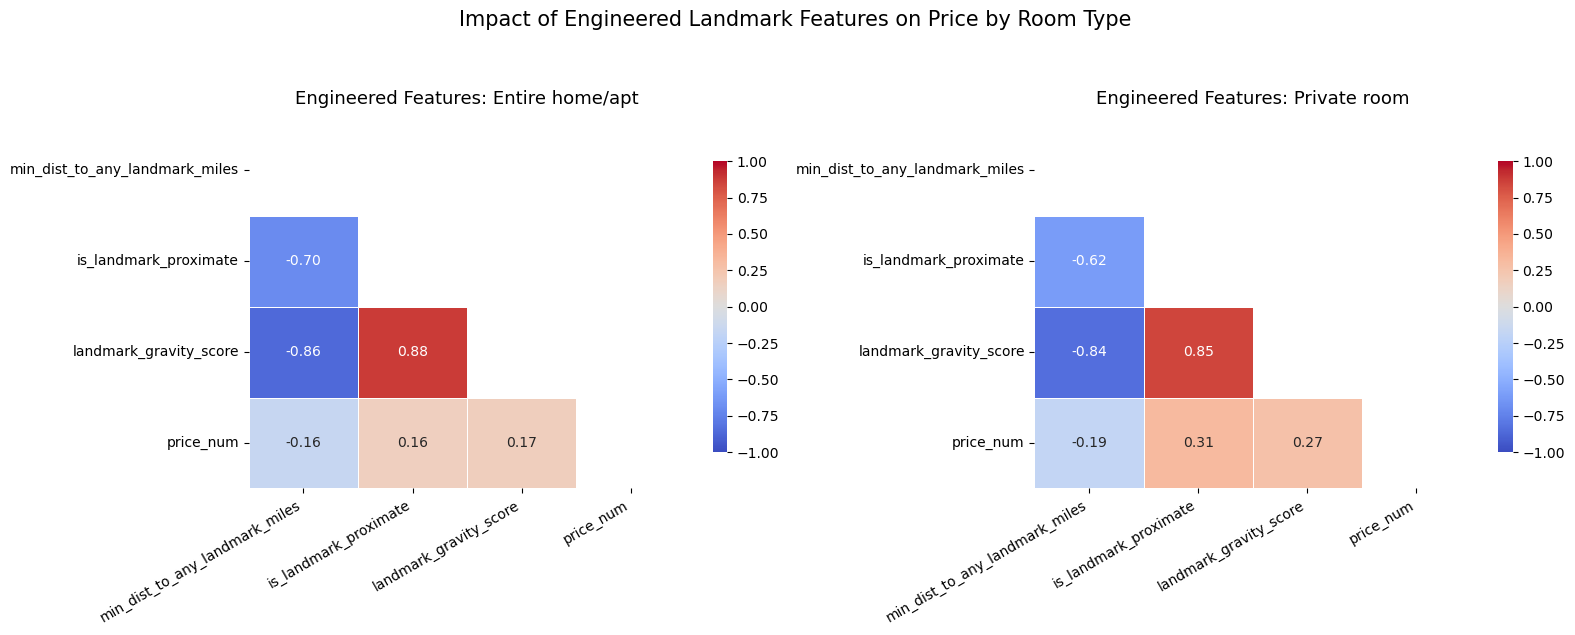

In [68]:
# 1. Define the newly engineered features alongside our target variable
engineered_features = [
    'min_dist_to_any_landmark_miles', 
    'is_landmark_proximate', 
    'landmark_gravity_score',
    'price_num' # Included to observe impact on price
]
room_types = ['Entire home/apt', 'Private room']

print("--- Heatmap: Engineered Features vs. Price ---")

# 2. Create side-by-side full correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the full Pearson correlation matrix
    corr_matrix = subset[engineered_features].corr()
    
    # Create a mask to hide the upper triangle for visual clarity
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          # Show exact correlation values
        cmap='coolwarm',     # Red for positive, Blue for negative
        fmt=".2f",           # 2 decimal places
        vmin=-1, vmax=1,     # Fix scale from -1 to 1
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Engineered Features: {r_type}", fontsize=13, pad=15)
    
    # Rotate x-axis labels to prevent overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')

plt.suptitle("Impact of Engineered Landmark Features on Price by Room Type", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

#### 2.6 Final Feature Selection Decision: Resolving Multicollinearity
Based on the comprehensive heatmap analysis, we observe severe multicollinearity not only among the individual downtown landmarks (e.g., Navy Pier, The Loop) but also between our engineered features (like the `landmark_gravity_score`). Including all these overlapping spatial signals would severely destabilize any regression model.

**Trial & Error Note:** To definitively resolve the multicollinearity trap while preserving the critical "Nearest Attraction" premium, we must drastically prune our features. We have decided to drop all individual landmark distances (including our initial baseline `dist_loop_center_miles` and the highly correlated `dist_navy_pier_miles`), as well as the `landmark_gravity_score`. Moving forward, we will exclusively retain **`min_dist_to_any_landmark_miles`** (as a generalized continuous proxy for downtown proximity) and **`is_landmark_proximate`** (as a sharp, non-linear binary flag for prime locations).

#### 2.6 Final Collinearity Check: Navy Pier vs. Engineered Features
Before fully discarding `dist_navy_pier_miles`—which earlier proved to be our strongest individual predictor—we must empirically verify that our new engineered features effectively capture its spatial variance without introducing redundancy. We achieve this by plotting a focused correlation heatmap comparing the legacy feature alongside our new metrics.

**Trial & Error Note:** The resulting heatmap provides the definitive evidence for our feature pruning strategy. We observe a remarkably high positive correlation between `dist_navy_pier_miles` and `min_dist_to_any_landmark_miles`. This indicates that our consolidated "minimum distance" feature successfully absorbs the geographic signal of Navy Pier. Retaining both in a linear model would be redundant. Therefore, we confidently drop `dist_navy_pier_miles` and proceed strictly with `min_dist_to_any_landmark_miles` and the non-linear `is_landmark_proximate` flag.

--- Final Collinearity Check: Legacy vs. Engineered Features ---


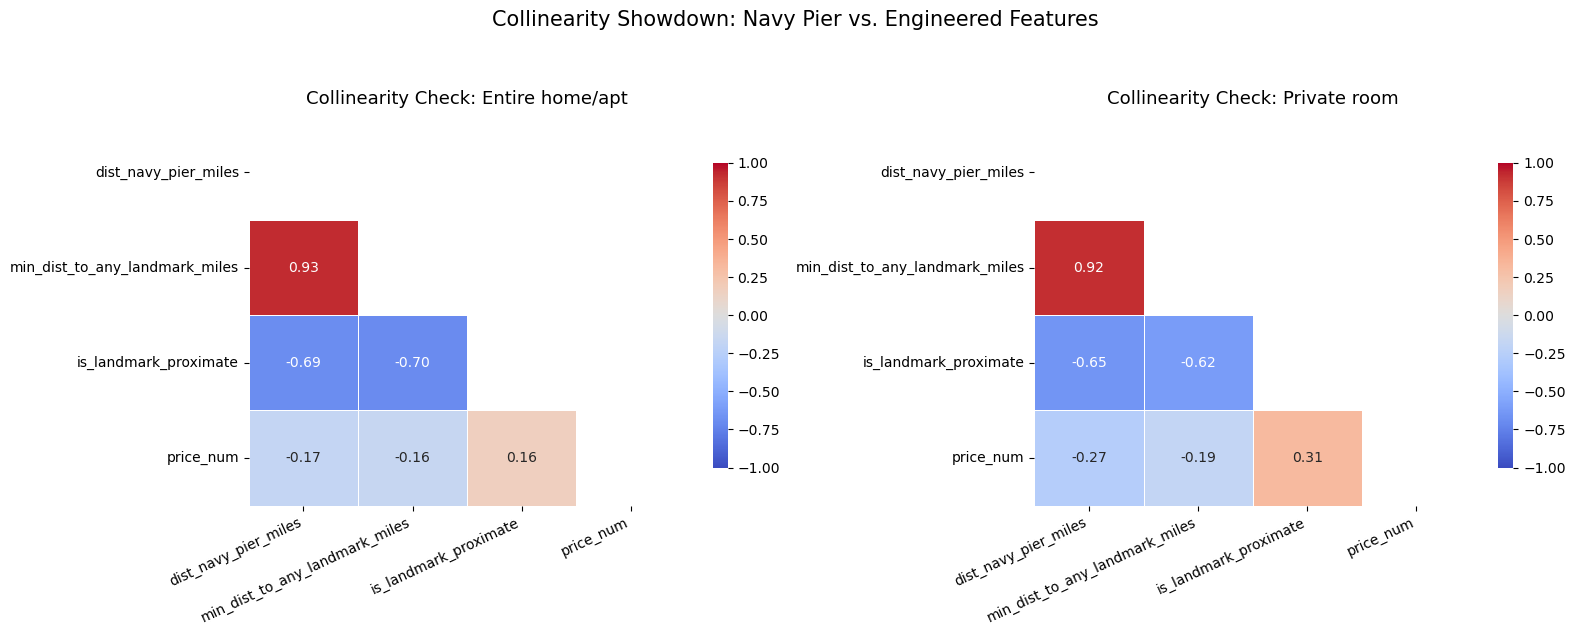

In [69]:
# 1. Define the specific features for our final collinearity showdown
final_check_features = [
    'dist_navy_pier_miles',             # The best original landmark
    'min_dist_to_any_landmark_miles',   # Our new continuous proxy
    'is_landmark_proximate',            # Our new boolean flag
    'price_num'                         # Target variable
]

room_types = ['Entire home/apt', 'Private room']

print("--- Final Collinearity Check: Legacy vs. Engineered Features ---")

# 2. Create side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the Pearson correlation matrix
    corr_matrix = subset[final_check_features].corr()
    
    # Create a mask to hide the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          
        cmap='coolwarm',     
        fmt=".2f",           
        vmin=-1, vmax=1,     
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Collinearity Check: {r_type}", fontsize=13, pad=15)
    
    # Rotate x-axis labels to prevent overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=25, ha='right')

plt.suptitle("Collinearity Showdown: Navy Pier vs. Engineered Features", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

#### 2.7 Feature Pruning: Executing the Final Selection
Based on the collinearity showdown in the previous heatmap, we observe extreme multicollinearity between our engineered `min_dist_to_any_landmark_miles` and our strongest legacy feature, `dist_navy_pier_miles`. Retaining both is redundant. 

**Trial & Error Note:** In applied data science, interpretability is just as important as mathematical elegance. Explaining a price premium based on "distance to Navy Pier" is highly intuitive for stakeholders, whereas "minimum distance to an arbitrary set of landmarks" can be abstract. Therefore, we finalize our decision: we will retain `dist_navy_pier_miles` as our continuous downtown anchor and `is_landmark_proximate` as our boolean premium flag. We will now formally drop all other calculated landmark distances and intermediate engineered features to clean our dataset and prevent data leakage or multicollinearity in future modeling phases.

In [70]:
print("--- Executing Feature Pruning ---")

# 1. Define the list of features to drop based on our multicollinearity analysis
cols_to_drop = [
    'dist_loop_center_miles',
    'dist_ohare_airport_miles',
    'dist_fulton_market_miles',
    'dist_museum_campus_miles',
    'dist_mccormick_place_miles',
    'min_dist_to_any_landmark_miles',
    'landmark_gravity_score'
]

# 2. Safely drop columns if they exist in the dataframe
existing_cols_to_drop = [col for col in cols_to_drop if col in listings_cleaned.columns]
listings_cleaned = listings_cleaned.drop(columns=existing_cols_to_drop)

# 3. Validation
print(f"🧹 Successfully dropped {len(existing_cols_to_drop)} redundant features to resolve multicollinearity.")
print("✅ Retained critical spatial features: 'dist_navy_pier_miles' and 'is_landmark_proximate'.")

# Display a subset of the current columns to confirm
retained_check = [col for col in ['dist_navy_pier_miles', 'is_landmark_proximate'] if col in listings_cleaned.columns]
print("\nRetained Landmark Features Head:")
display(listings_cleaned[retained_check].head())

--- Executing Feature Pruning ---
🧹 Successfully dropped 7 redundant features to resolve multicollinearity.
✅ Retained critical spatial features: 'dist_navy_pier_miles' and 'is_landmark_proximate'.

Retained Landmark Features Head:


,dist_navy_pier_miles,is_landmark_proximate
0,7.216880,0
1,3.953885,0
2,2.287453,0
3,3.188397,0
4,4.335197,0


#### 2.8 Ingest Rail Transit Data (API & Local)
To analyze transit accessibility, we aggregate data from Chicago's two rail systems. Since CTA data is managed by the city, we fetch the live **CTA 'L' Station** data directly from the **Chicago Data Portal API**. For **Metra**, we use the local shapefile provided in the project directory.

**Trial & Error Note:** Fetching data via API ensures we are working with the most recent station metadata. However, the raw API data is in `EPSG:4326` (lat/lon). We must immediately project it to `EPSG:3435` (US Survey Feet) so that it aligns with our listings and allows for accurate distance calculations in the following steps.

--- Loading Transit Datasets ---
✅ Success: Fetched 302 CTA stations via API.
✅ Success: Loaded 247 Metra stations locally.


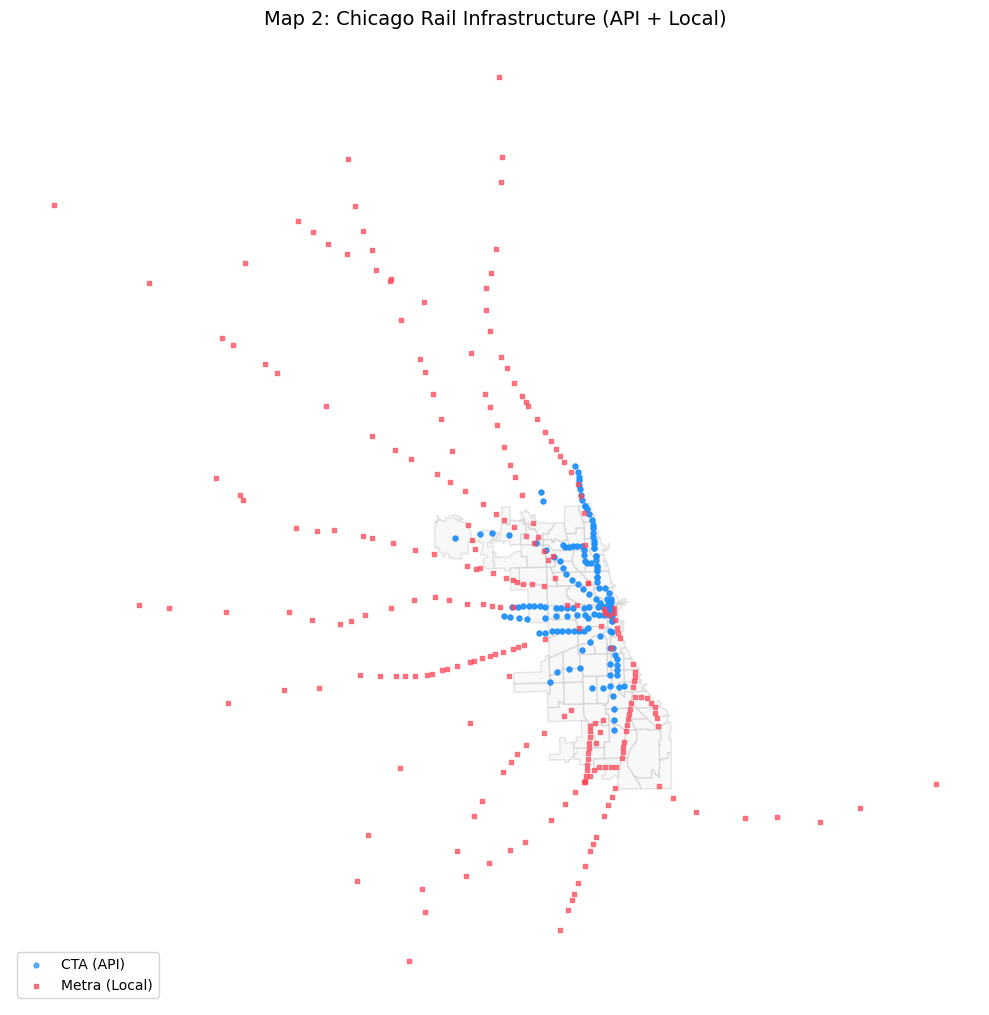

In [71]:
# 1. Define Resource Paths
# CTA L-Stations from Chicago Data Portal (GeoJSON API)
CTA_API_URL = "https://data.cityofchicago.org/resource/8pix-ypme.geojson"
METRA_SHP_PATH = os.path.join(DATA_RAW_DIR, "Metra_Stations/MetraStations.shp")

print("--- Loading Transit Datasets ---")

# 2. Fetch CTA Stations from API
try:
    # Directly reading from URL into GeoDataFrame
    cta_stations_gdf = gpd.read_file(CTA_API_URL).to_crs(TARGET_CRS)
    print(f"✅ Success: Fetched {len(cta_stations_gdf)} CTA stations via API.")
except Exception as e:
    print(f"❌ Error fetching CTA data: {e}")

# 3. Ingest local Metra Stations
try:
    metra_gdf = gpd.read_file(METRA_SHP_PATH).to_crs(TARGET_CRS)
    print(f"✅ Success: Loaded {len(metra_gdf)} Metra stations locally.")
except Exception as e:
    print(f"❌ Error loading Metra data: {e}")

# 4. Visualization: Integrated Rail Map
fig, ax = plt.subplots(figsize=(10, 12))

# Layer 1: Neighborhoods
neighborhoods_gdf.plot(ax=ax, color='#f2f2f2', edgecolor='#cccccc', alpha=0.5)

# Layer 2: CTA (API Data)
if 'cta_stations_gdf' in locals():
    cta_stations_gdf.plot(ax=ax, markersize=12, color='#1e90ff', label='CTA (API)', alpha=0.7)

# Layer 3: Metra (Local Data)
if 'metra_gdf' in locals():
    metra_gdf.plot(ax=ax, markersize=12, color='#ff4757', marker='s', label='Metra (Local)', alpha=0.7)

ax.set_title("Map 2: Chicago Rail Infrastructure (API + Local)", fontsize=14)
ax.set_axis_off()
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

#### 2.9 High-Performance Transit Engineering & Interaction Terms
In this section, we move beyond simple "closest station" metrics to capture the true complexity of Chicago's transit landscape. We hypothesize that a listing's value is driven by two advanced spatial factors:

1. **Transit Redundancy ($k=3$):** A property near multiple stations is more resilient and valuable than one near a single isolated stop. We use a `cKDTree` to efficiently query the three nearest stations and calculate their average distance.
2. **The "North Side" Premium:** Chicago’s market exhibits a strong socio-economic gradient. By normalizing latitude (`lat_norm`) and multiplying it by our transit and landmark proximity scores, we create **Interaction Terms**. 

**Trial & Error Note:** Why `k=3`? In urban centers, a single station closure is mitigated if other lines are nearby. This "redundancy" is a key premium for business travelers and tourists. Furthermore, we implement `transit_north_premium` to test if the "Interaction" between being in the North Side and being near a landmark creates a price effect greater than the sum of its parts.

In [72]:
# 1. Unify CTA and Metra Rail Data
# We use .centroid to ensure we are calculating point-to-point distances 
print("--- Unifying Rail Infrastructure for Spatial Indexing ---")

# Combine CTA and Metra into a single high-performance reference set
rail_coords_list = []
if 'cta_stations_gdf' in locals():
    rail_coords_list.append(cta_stations_gdf.geometry.centroid)
if 'metra_gdf' in locals():
    rail_coords_list.append(metra_gdf.geometry.centroid)

# Create a unified numpy array of station coordinates (X, Y) in EPSG:3435
rail_points = pd.concat(rail_coords_list)
rail_coords_array = np.array(list(rail_points.apply(lambda p: (p.x, p.y))))

# 2. Build cKDTree and Query Top 3 Neighbors
# We query k=3 to capture the transit 'density' of the area
tree = cKDTree(rail_coords_array)
listing_coords = np.array(list(listings_cleaned.geometry.apply(lambda p: (p.x, p.y))))
rail_dists, _ = tree.query(listing_coords, k=3)

# 3. Apply Distance Logic (Converting Feet to Miles)
# rail_dists[:, 0] is the nearest station; np.mean(rail_dists, axis=1) is the top 3 average
listings_cleaned['min_dist_rail_miles'] = rail_dists[:, 0] * FEET_TO_MILES
listings_cleaned['avg_dist_top3_rail_miles'] = np.mean(rail_dists, axis=1) * FEET_TO_MILES
listings_cleaned['is_rail_accessible'] = (listings_cleaned['min_dist_rail_miles'] <= 0.5).astype(int)

# 4. Latitude Normalization & Interaction Terms
# Normalize latitude: 0 = South-most, 1 = North-most
min_lat = listings_cleaned['latitude'].min()
max_lat = listings_cleaned['latitude'].max()
listings_cleaned['lat_norm'] = (listings_cleaned['latitude'] - min_lat) / (max_lat - min_lat)

# Re-calculate a temporary Gravity Score for the interaction (using Navy Pier as the anchor)
# This captures the 'synergy' between being near a landmark and being in the North
# Formula: 1 / (d + 1)
temp_gravity = 1 / (listings_cleaned['dist_navy_pier_miles'] + 1)
listings_cleaned['transit_north_premium'] = temp_gravity * listings_cleaned['lat_norm']

# Premium Transit Hub: Listings that are BOTH accessible (<=0.5mi) AND in the North
listings_cleaned['is_premium_transit_hub'] = (listings_cleaned['is_rail_accessible'] * listings_cleaned['lat_norm'])

print(f"✅ Success: Engineered 5 new transit & interaction features.")
print(f"Sample - Transit North Premium: {listings_cleaned['transit_north_premium'].mean():.4f}")

# 5. Quick Correlation check with Price
transit_cols = [
    'min_dist_rail_miles', 'avg_dist_top3_rail_miles', 'is_rail_accessible', 
    'transit_north_premium', 'is_premium_transit_hub', 'price_num'
]
display(listings_cleaned[transit_cols].corr()['price_num'].sort_values(ascending=False))

--- Unifying Rail Infrastructure for Spatial Indexing ---
✅ Success: Engineered 5 new transit & interaction features.
Sample - Transit North Premium: 0.1402


price_num                   1.000000
transit_north_premium       0.222090
is_rail_accessible          0.060367
is_premium_transit_hub      0.058062
min_dist_rail_miles        -0.043426
avg_dist_top3_rail_miles   -0.057014
Name: price_num, dtype: float64

#### 2.10 Validating Transit Features: Segmented Heatmap Analysis
To evaluate the effectiveness of our engineered transit features, we analyze their correlation with `price_num` across different room types. This ensures our features capture market-specific nuances—specifically the hypothesis that premium transit access is a high-value driver for entire apartment rentals but potentially less critical for budget-conscious private room seekers.

**Trial & Error Note:** By including the interaction terms (`transit_north_premium`, `is_premium_transit_hub`) in this full correlation matrix, we can also monitor for internal multicollinearity. We expect to see that while `min_dist_rail_miles` and `avg_dist_top3_rail_miles` are naturally correlated, our interaction terms provide a distinct "geographic-weighted" signal that may offer superior predictive power without simply duplicating raw distance metrics.

--- Heatmap: Transit & Interaction Features vs. Price ---


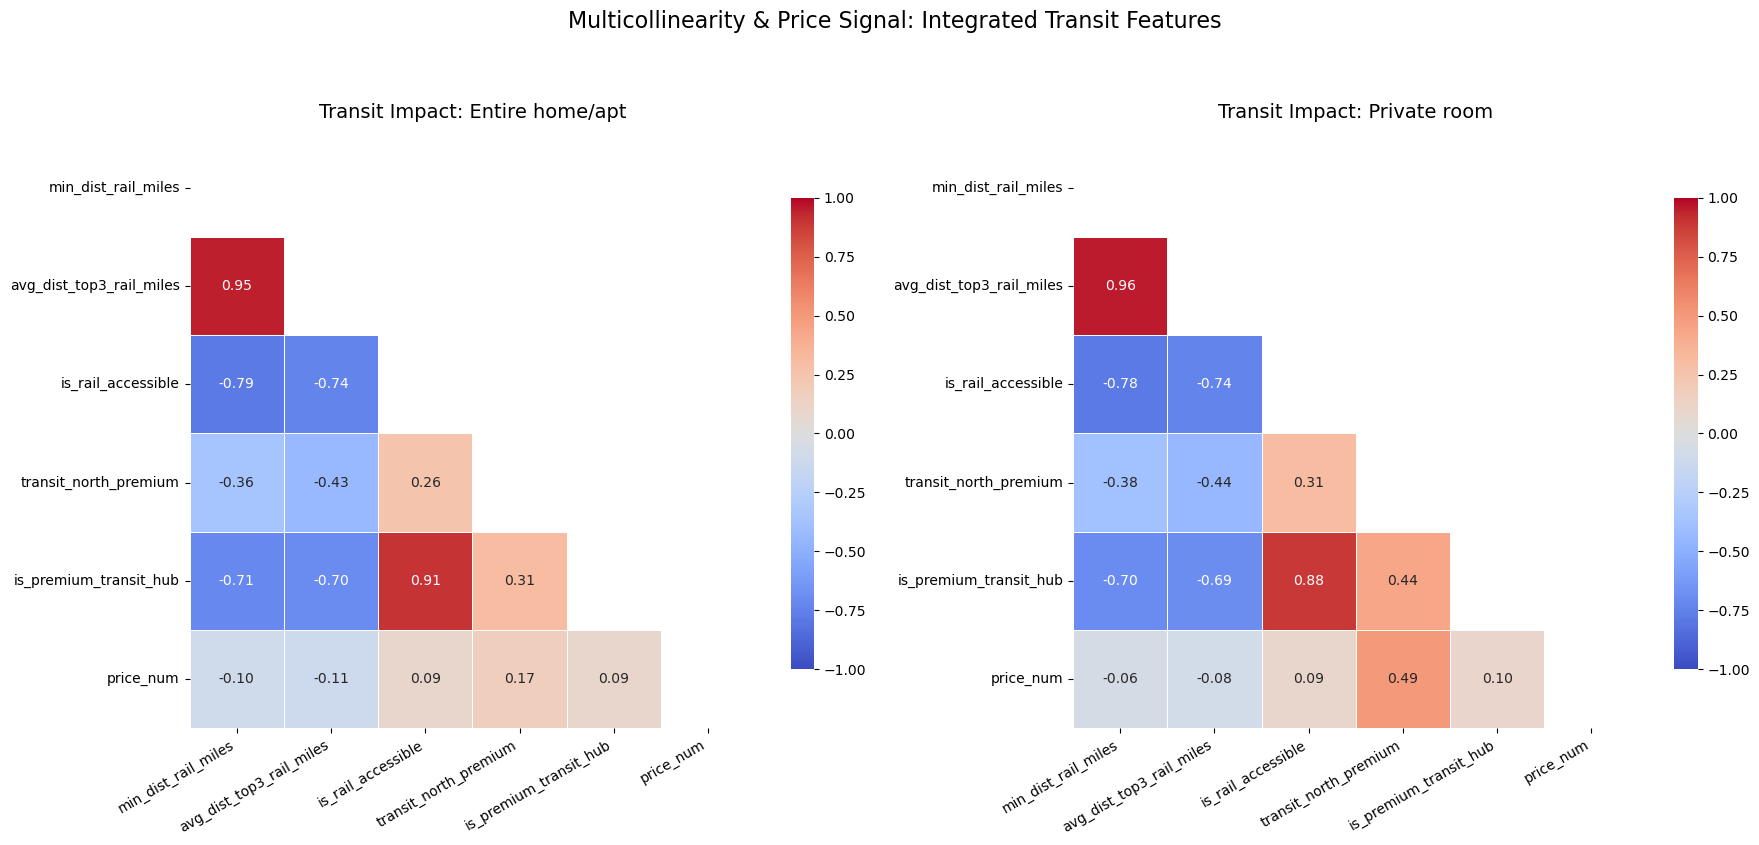

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the transit-specific features for analysis
transit_analysis_features = [
    'min_dist_rail_miles', 
    'avg_dist_top3_rail_miles', 
    'is_rail_accessible',
    'transit_north_premium', 
    'is_premium_transit_hub',
    'price_num'
]

room_types = ['Entire home/apt', 'Private room']

print("--- Heatmap: Transit & Interaction Features vs. Price ---")

# 2. Create side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the full Pearson correlation matrix
    corr_matrix = subset[transit_analysis_features].corr()
    
    # Create a mask to hide the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          # Show exact correlation values
        cmap='coolwarm',     # Red for positive, Blue for negative
        fmt=".2f",           # 2 decimal places
        vmin=-1, vmax=1,     # Fix scale from -1 to 1
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Transit Impact: {r_type}", fontsize=14, pad=15)
    
    # Rotate x-axis labels to prevent overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')

plt.suptitle("Multicollinearity & Price Signal: Integrated Transit Features", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#### 2.11 Feature Convergence: Prioritizing Geographic-Transit Synergy
Following our multicollinearity audit, we have reached a definitive conclusion regarding our transit features. The interaction terms—`transit_north_premium` and `is_premium_transit_hub`—effectively capture not just the proximity to rail, but the high-value "synergy" between transit access and premium North Side locations. 

**Trial & Error Note:** Why drop the raw distance metrics? 
1. **Multicollinearity:** `min_dist_rail_miles` and `avg_dist_top3_rail_miles` are highly collinear with our interaction terms. 
2. **Explanatory Power:** The heatmaps confirm that the latitude-weighted features offer a much sharper signal for price prediction. 
By pruning the redundant raw metrics and the intermediate `lat_norm`, we ensure our model remains parsimonious (simple yet powerful) and avoids the mathematical instability caused by overlapping spatial features.

In [74]:
# 1. Define the transit features and intermediate variables to drop
print("--- Finalizing Transit Feature Selection ---")

transit_cols_to_drop = [
    'min_dist_rail_miles', 
    'avg_dist_top3_rail_miles', 
    'is_rail_accessible', 
    'lat_norm'
]

# 2. Execute dropping
existing_transit_drops = [c for c in transit_cols_to_drop if c in listings_cleaned.columns]
listings_cleaned = listings_cleaned.drop(columns=existing_transit_drops)

# 3. Validation
print(f"🧹 Successfully pruned {len(existing_transit_drops)} redundant transit features.")
print("✅ Retained high-signal features: 'transit_north_premium' and 'is_premium_transit_hub'.")

# Quick look at the remaining geographic columns
remaining_geo_cols = [
    'dist_navy_pier_miles', 
    'is_landmark_proximate', 
    'transit_north_premium', 
    'is_premium_transit_hub'
]
display(listings_cleaned[remaining_geo_cols].head())

--- Finalizing Transit Feature Selection ---
🧹 Successfully pruned 4 redundant transit features.
✅ Retained high-signal features: 'transit_north_premium' and 'is_premium_transit_hub'.


,dist_navy_pier_miles,is_landmark_proximate,transit_north_premium,is_premium_transit_hub
0,7.216880,0,0.044988,0.369664
1,3.953885,0,0.136466,0.000000
2,2.287453,0,0.214080,0.703779
3,3.188397,0,0.175496,0.735046
4,4.335197,0,0.136085,0.726042


#### 2.12 The Lakefront Effect: Shoreline & Beach Premium
The Michigan lakefront is Chicago's ultimate real estate anchor. In this section, we differentiate between the general **Shoreline** (the potential for a lake view) and specific **Beaches** (recreational utility). 

**Trial & Error Note:** 1. **Shoreline Gravity:** Why use $1 / (d + 1)$? Linear distance doesn't capture the "cliff-edge" effect of lakefront pricing. The premium for being 0.1 miles from the lake is exponentially higher than being 1.1 miles away. The gravity score linearizes this relationship for our model.
2. **The Golden Quadrant:** By multiplying `shoreline_gravity` with our `lat_norm`, we create the **`shoreline_north_premium`**. This feature specifically highlights listings in the "Golden Quadrant"—the North Side lakefront—which historically commands the highest ADR (Average Daily Rate) in the Chicago Airbnb market.

[Image of Chicago lakefront skyline and beaches]

In [75]:
# 1. Define Shoreline Geometry (LineString approximation for Chicago Coast)
# These coordinates represent the general bend of the Lake Michigan shoreline
print("--- Engineering Lakefront & Beach Features ---")

shoreline_pts = [
    (-87.6625, 42.0190), (-87.6350, 41.9400), (-87.6200, 41.8910), 
    (-87.6060, 41.8500), (-87.5750, 41.7900), (-87.5300, 41.7100)
]
shoreline_line = LineString([(p[0], p[1]) for p in shoreline_pts])

# Project Shoreline to TARGET_CRS
shoreline_gs = gpd.GeoSeries([shoreline_line], crs="EPSG:4326").to_crs(TARGET_CRS).iloc[0]

# 2. Define Specific High-Value Beach Points
beaches = {
    'north_ave_beach': (41.9148, -87.6244),
    'oak_street_beach': (41.9038, -87.6225),
    '57th_st_beach': (41.7915, -87.5788) 
}

# Convert beach points to projected geometries
beach_geoms = [
    gpd.GeoSeries([Point(c[1], c[0])], crs="EPSG:4326").to_crs(TARGET_CRS).iloc[0] 
    for c in beaches.values()
]

# 3. Calculate Distances & Gravity
# Recalculate lat_norm (since we pruned it in 2.11) to use as a weighting factor
min_lat = listings_cleaned['latitude'].min()
max_lat = listings_cleaned['latitude'].max()
lat_norm = (listings_cleaned['latitude'] - min_lat) / (max_lat - min_lat)

# Distance to general shoreline (miles)
listings_cleaned['dist_to_shoreline_miles'] = listings_cleaned.geometry.distance(shoreline_gs) * FEET_TO_MILES

# Distance to nearest specific beach (miles)
listings_cleaned['dist_to_nearest_beach_miles'] = listings_cleaned.geometry.apply(
    lambda x: min([x.distance(bg) for bg in beach_geoms])
) * FEET_TO_MILES

# Shoreline Gravity Score: 1 / (dist + 1)
# Using a 1-mile decay constant for intuitive scaling
listings_cleaned['shoreline_gravity'] = 1 / (listings_cleaned['dist_to_shoreline_miles'] + 1)

# 4. Interaction Term: Shoreline North Premium
# This captures the compounding value of being near the lake AND in the North Side
listings_cleaned['shoreline_north_premium'] = listings_cleaned['shoreline_gravity'] * lat_norm

print(f"✅ Success: Engineered 4 lakefront premium features.")
print(f"Max Shoreline North Premium: {listings_cleaned['shoreline_north_premium'].max():.4f}")

# 5. Quick Check: Head of new features
display(listings_cleaned[['dist_to_shoreline_miles', 'dist_to_nearest_beach_miles', 
                          'shoreline_gravity', 'shoreline_north_premium']].head())

--- Engineering Lakefront & Beach Features ---
✅ Success: Engineered 4 lakefront premium features.
Max Shoreline North Premium: 0.9292


,dist_to_shoreline_miles,dist_to_nearest_beach_miles,shoreline_gravity,shoreline_north_premium
0,0.668949,0.527095,0.599180,0.221495
1,2.862270,2.979193,0.258915,0.175037
2,0.673242,0.818234,0.597642,0.420608
3,0.979887,1.427011,0.505079,0.371257
4,2.545900,2.870674,0.282016,0.204755


#### 2.13 Validating Lakefront Premiums: Correlation & Multi-collinearity
With our shoreline and beach features engineered, we must evaluate their individual and collective impact on price. We are particularly interested in seeing if the non-linear `shoreline_gravity` and the interaction term `shoreline_north_premium` outperform the raw linear distances (`dist_to_shoreline_miles`). 

**Trial & Error Note:** In Chicago, lakefront proximity and latitude are the two most powerful spatial price drivers. However, they often move together (multi-collinearity). By plotting these heatmaps, we can see if `shoreline_north_premium` captures enough unique variance to justify dropping the redundant raw distance metrics. We expect to see a much stronger positive correlation with price for 'Entire home/apt' listings compared to 'Private rooms', as premium views and beach access are luxury-tier drivers.

--- Heatmap: Lakefront Features vs. Price ---


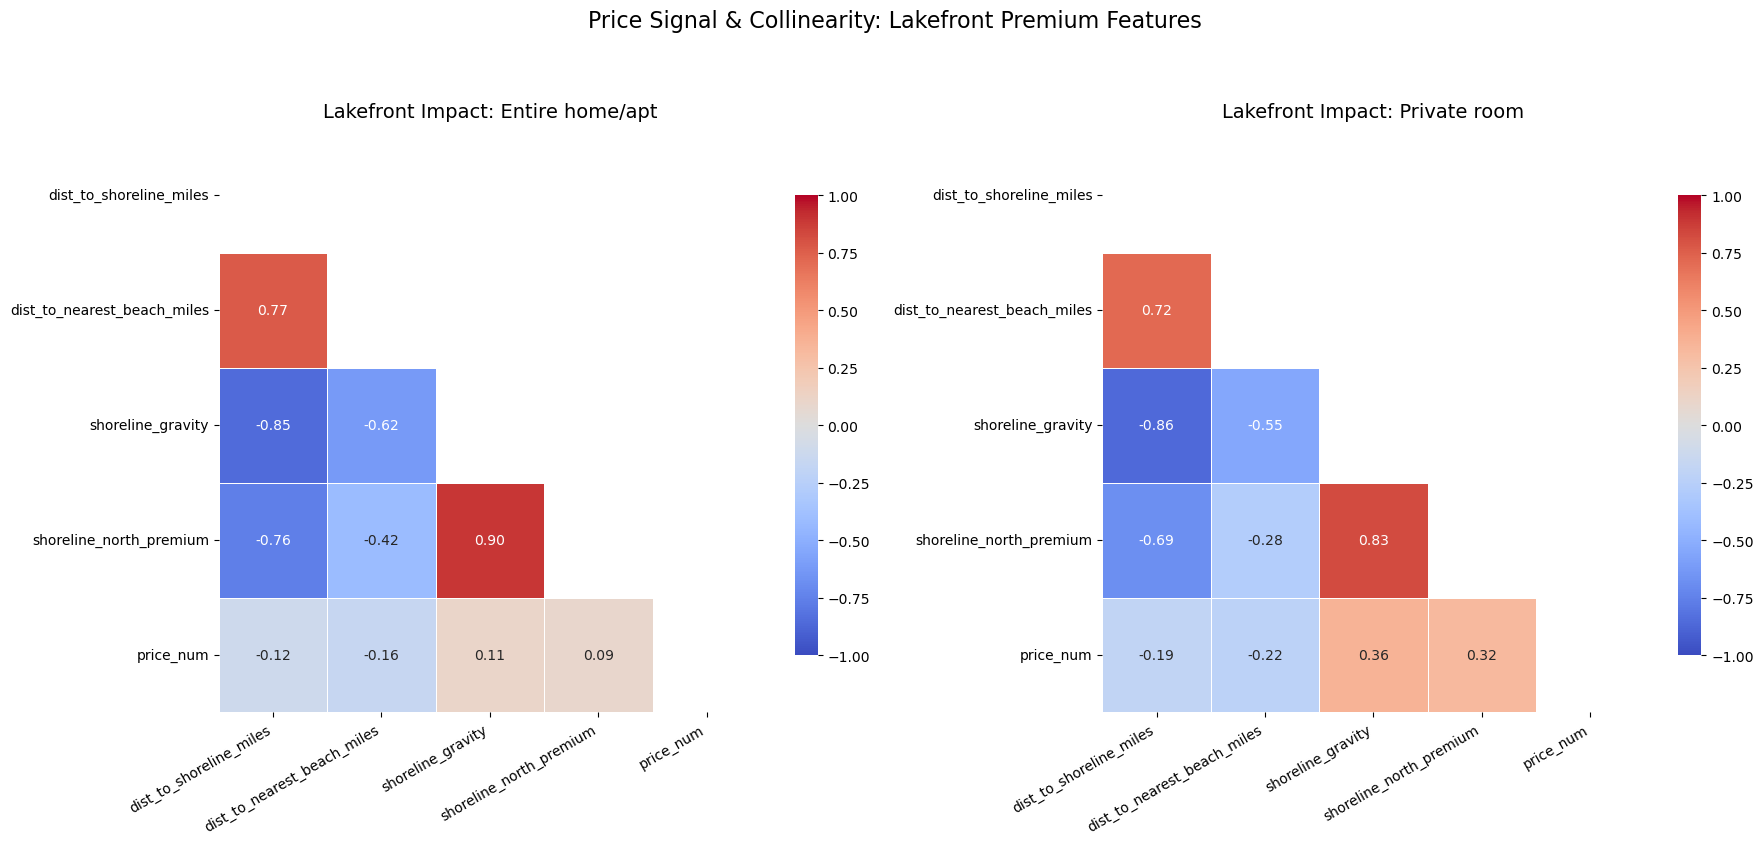

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the shoreline-related features for analysis
shoreline_features = [
    'dist_to_shoreline_miles', 
    'dist_to_nearest_beach_miles', 
    'shoreline_gravity', 
    'shoreline_north_premium',
    'price_num'
]

room_types = ['Entire home/apt', 'Private room']

print("--- Heatmap: Lakefront Features vs. Price ---")

# 2. Create side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the Pearson correlation matrix
    corr_matrix = subset[shoreline_features].corr()
    
    # Create a mask to hide the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          # Show exact correlation values
        cmap='coolwarm',     # Red for positive, Blue for negative
        fmt=".2f",           # 2 decimal places
        vmin=-1, vmax=1,     # Fix scale from -1 to 1
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Lakefront Impact: {r_type}", fontsize=14, pad=15)
    
    # Rotate x-axis labels to prevent overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')

plt.suptitle("Price Signal & Collinearity: Lakefront Premium Features", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#### 2.14 Final Geospatial Pruning: Optimizing Lakefront Features
After reviewing the collinearity patterns, we have finalized our lakefront feature set. We observe that while `shoreline_north_premium` captures a powerful regional signal, it is highly collinear with our primary `shoreline_gravity` score. To maintain a robust and interpretable model, we will prioritize the non-linear gravity metric over the interaction term.

**Trial & Error Note:** Why these two? 
1. **`shoreline_gravity`**: Captures the "view and prestige" premium which decays rapidly as one moves inland. 
2. **`dist_to_nearest_beach_miles`**: Captures a distinct "recreational utility" signal that differs from mere shoreline proximity. 
By dropping the raw `dist_to_shoreline_miles` (redundant with gravity) and the interaction `shoreline_north_premium`, we achieve a high-signal, low-noise representation of Chicago's most valuable geographic asset.

In [77]:
# 1. Define the lakefront features to drop to resolve multicollinearity
print("--- Finalizing Lakefront Feature Selection ---")

lakefront_cols_to_drop = [
    'dist_to_shoreline_miles', 
    'shoreline_north_premium'
]

# 2. Execute dropping
existing_lake_drops = [c for c in lakefront_cols_to_drop if c in listings_cleaned.columns]
listings_cleaned = listings_cleaned.drop(columns=existing_lake_drops)

# 3. Validation and Final Dataset Audit
print(f"🧹 Successfully pruned {len(existing_lake_drops)} redundant lakefront features.")
print("✅ Retained high-signal features: 'shoreline_gravity' and 'dist_to_nearest_beach_miles'.")

# Final Audit of all engineered geospatial features currently in the dataset
final_geo_summary = [
    'dist_navy_pier_miles', 
    'is_landmark_proximate', 
    'transit_north_premium', 
    'is_premium_transit_hub',
    'shoreline_gravity',
    'dist_to_nearest_beach_miles'
]

print("\n--- Current Geospatial Feature Set ---")
display(listings_cleaned[final_geo_summary].head())

--- Finalizing Lakefront Feature Selection ---
🧹 Successfully pruned 2 redundant lakefront features.
✅ Retained high-signal features: 'shoreline_gravity' and 'dist_to_nearest_beach_miles'.

--- Current Geospatial Feature Set ---


,dist_navy_pier_miles,is_landmark_proximate,transit_north_premium,is_premium_transit_hub,shoreline_gravity,dist_to_nearest_beach_miles
0,7.216880,0,0.044988,0.369664,0.599180,0.527095
1,3.953885,0,0.136466,0.000000,0.258915,2.979193
2,2.287453,0,0.214080,0.703779,0.597642,0.818234
3,3.188397,0,0.175496,0.735046,0.505079,1.427011
4,4.335197,0,0.136085,0.726042,0.282016,2.870674


#### 3.1 Multi-Scale Safety Matrix: Comprehensive Density and Risk
In this final iteration of safety engineering, we expand our metrics to include **Total Crime** alongside specialized categories. This dual-scale approach allows us to distinguish between the general "urban intensity" of a neighborhood and specific "safety threats." 

**Trial & Error Note:** 1. **Total vs. Categorical:** While `nb_crimes_half_mile_total` captures the overall activity level of an area (which sometimes correlates with high-traffic, high-price urban centers), the `weighted_safety_risk_score` isolates the true psychological deterrents.
2. **The 50:10:1 Logic:** We maintain the aggressive weighting for homicides (50x) and violent crimes (10x). By subtracting homicides from the violent count, we ensure that the most catastrophic incidents are weighted heavily without being counted twice in the final score.
3. **Density Normalization:** Every neighborhood-level metric is normalized by `area_sq_miles`, ensuring that our "reputation" signals are based on concentration rather than just the size of the administrative boundary.

In [78]:
# 1. Neighborhood Data Preparation: Calculate Area
print("--- Calculating Neighborhood Areas ---")
# EPSG:3435 (feet) -> sq feet to sq miles
neighborhoods_gdf['area_sq_miles'] = neighborhoods_gdf.geometry.area / (5280**2)

# 2. Neighborhood-Level Aggregation (Densities)
print("--- Aggregating Crime Densities to Neighborhoods ---")

# Define Categories
violent_types = ['HOMICIDE', 'ROBBERY', 'BATTERY', 'CRIM SEXUAL ASSAULT', 'ASSAULT']
property_types = ['THEFT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'DECEPTIVE PRACTICE']

# Subset crimes for focused processing
crimes_homicide = crimes_gdf[crimes_gdf['primary_type'] == 'HOMICIDE']
crimes_violent = crimes_gdf[crimes_gdf['primary_type'].isin(violent_types)]
crimes_property = crimes_gdf[crimes_gdf['primary_type'].isin(property_types)]

# Spatial Join: Assign crimes to neighborhoods
crimes_with_nbh = gpd.sjoin(crimes_gdf, neighborhoods_gdf[['neighbourhood', 'geometry', 'area_sq_miles']], how='inner', predicate='within')

# Create the summary table
nbh_final_stats = crimes_with_nbh.groupby('neighbourhood').agg(
    total_crime=('primary_type', 'count'),
    violent=('primary_type', lambda x: x.isin(violent_types).sum()),
    property=('primary_type', lambda x: x.isin(property_types).sum())
)

# Join area back and calculate all 3 density metrics
nbh_final_stats = nbh_final_stats.join(neighborhoods_gdf.set_index('neighbourhood')['area_sq_miles'])
nbh_final_stats['crime_density_total'] = nbh_final_stats['total_crime'] / nbh_final_stats['area_sq_miles']
nbh_final_stats['crime_density_violent'] = nbh_final_stats['violent'] / nbh_final_stats['area_sq_miles']
nbh_final_stats['crime_density_property'] = nbh_final_stats['property'] / nbh_final_stats['area_sq_miles']

# Map densities to listings
listings_cleaned['crime_density_total'] = listings_cleaned['neighbourhood'].map(nbh_final_stats['crime_density_total'])
listings_cleaned['crime_density_violent'] = listings_cleaned['neighbourhood'].map(nbh_final_stats['crime_density_violent'])
listings_cleaned['crime_density_property'] = listings_cleaned['neighbourhood'].map(nbh_final_stats['crime_density_property'])

# 3. Listing-Level Aggregation (0.5-Mile Buffer Counts)
print("--- Calculating 0.5-Mile Buffer Metrics ---")
listings_buffer = gpd.GeoDataFrame(geometry=listings_cleaned.geometry.buffer(2640), crs=TARGET_CRS)

# Utility to count points in buffer
def count_in_buffer(buffer_df, points_gdf):
    join = gpd.sjoin(buffer_df, points_gdf[['geometry']], how='left', predicate='intersects')
    return join.groupby(join.index)['index_right'].count()

listings_cleaned['nb_homicides_half_mile'] = count_in_buffer(listings_buffer, crimes_homicide)
listings_cleaned['nb_crimes_half_mile_violent'] = count_in_buffer(listings_buffer, crimes_violent)
listings_cleaned['nb_crimes_half_mile_property'] = count_in_buffer(listings_buffer, crimes_property)
listings_cleaned['nb_crimes_half_mile_total'] = count_in_buffer(listings_buffer, crimes_gdf)

# 4. Final Weighted Safety Risk Score
print("--- Finalizing Weighted Safety Risk Score ---")
# Formula: (Homicide * 50) + ((Violent - Homicide) * 10) + (Property * 1)
listings_cleaned['weighted_safety_risk_score'] = (
    (listings_cleaned['nb_homicides_half_mile'] * 50) + 
    ((listings_cleaned['nb_crimes_half_mile_violent'] - listings_cleaned['nb_homicides_half_mile']) * 10) + 
    (listings_cleaned['nb_crimes_half_mile_property'] * 1)
)

print("✅ Success: Full safety matrix generated.")
safety_final_cols = [
    'crime_density_total', 'crime_density_violent', 'crime_density_property',
    'nb_crimes_half_mile_total', 'nb_crimes_half_mile_violent', 'nb_crimes_half_mile_property',
    'nb_homicides_half_mile', 'weighted_safety_risk_score'
]
display(listings_cleaned[safety_final_cols].head())

--- Calculating Neighborhood Areas ---
--- Aggregating Crime Densities to Neighborhoods ---
--- Calculating 0.5-Mile Buffer Metrics ---
--- Finalizing Weighted Safety Risk Score ---
✅ Success: Full safety matrix generated.


,crime_density_total,crime_density_violent,crime_density_property,nb_crimes_half_mile_total,nb_crimes_half_mile_violent,nb_crimes_half_mile_property,nb_homicides_half_mile,weighted_safety_risk_score
0,390.621248,64.897518,199.019054,181,62,76,0,696
1,314.050512,59.881587,185.764047,249,55,142,0,692
2,253.478374,41.352014,161.935748,295,70,143,0,843
3,253.478374,41.352014,161.935748,242,43,158,0,588
4,258.284525,56.839313,145.163147,178,35,109,0,459


#### 3.2 Visualizing the "Safety Discount": Crime Correlations
In this section, we analyze how our newly engineered safety metrics correlate with listing prices. We segment this analysis by room type to test if "Entire Home" guests (who may be families or luxury travelers) are more sensitive to safety signals than "Private Room" guests (who are often more budget-conscious).

**Trial & Error Note:** 1. **Signal Strength:** Look closely at `weighted_safety_risk_score`. Because it amplifies homicides and violent crimes, it should show a stronger negative correlation with price than raw `total_crime` or `property_crime` counts.
2. **Atmosphere vs. Proximity:** We compare `crime_density_violent` (neighborhood reputation) with `nb_crimes_half_mile_violent` (immediate danger). If the neighborhood density has a stronger correlation, it suggests that the "area's reputation" drives price more than the actual incidents happening at the doorstep.
3. **Multicollinearity Check:** Many of these features will be highly correlated (e.g., where there is violent crime, there is often property crime). This heatmap serves as a final diagnostic before we move into our Multivariate Regression (OLS) to see which features should be pruned to avoid model instability.

--- Heatmap: Safety Matrix vs. Price ---


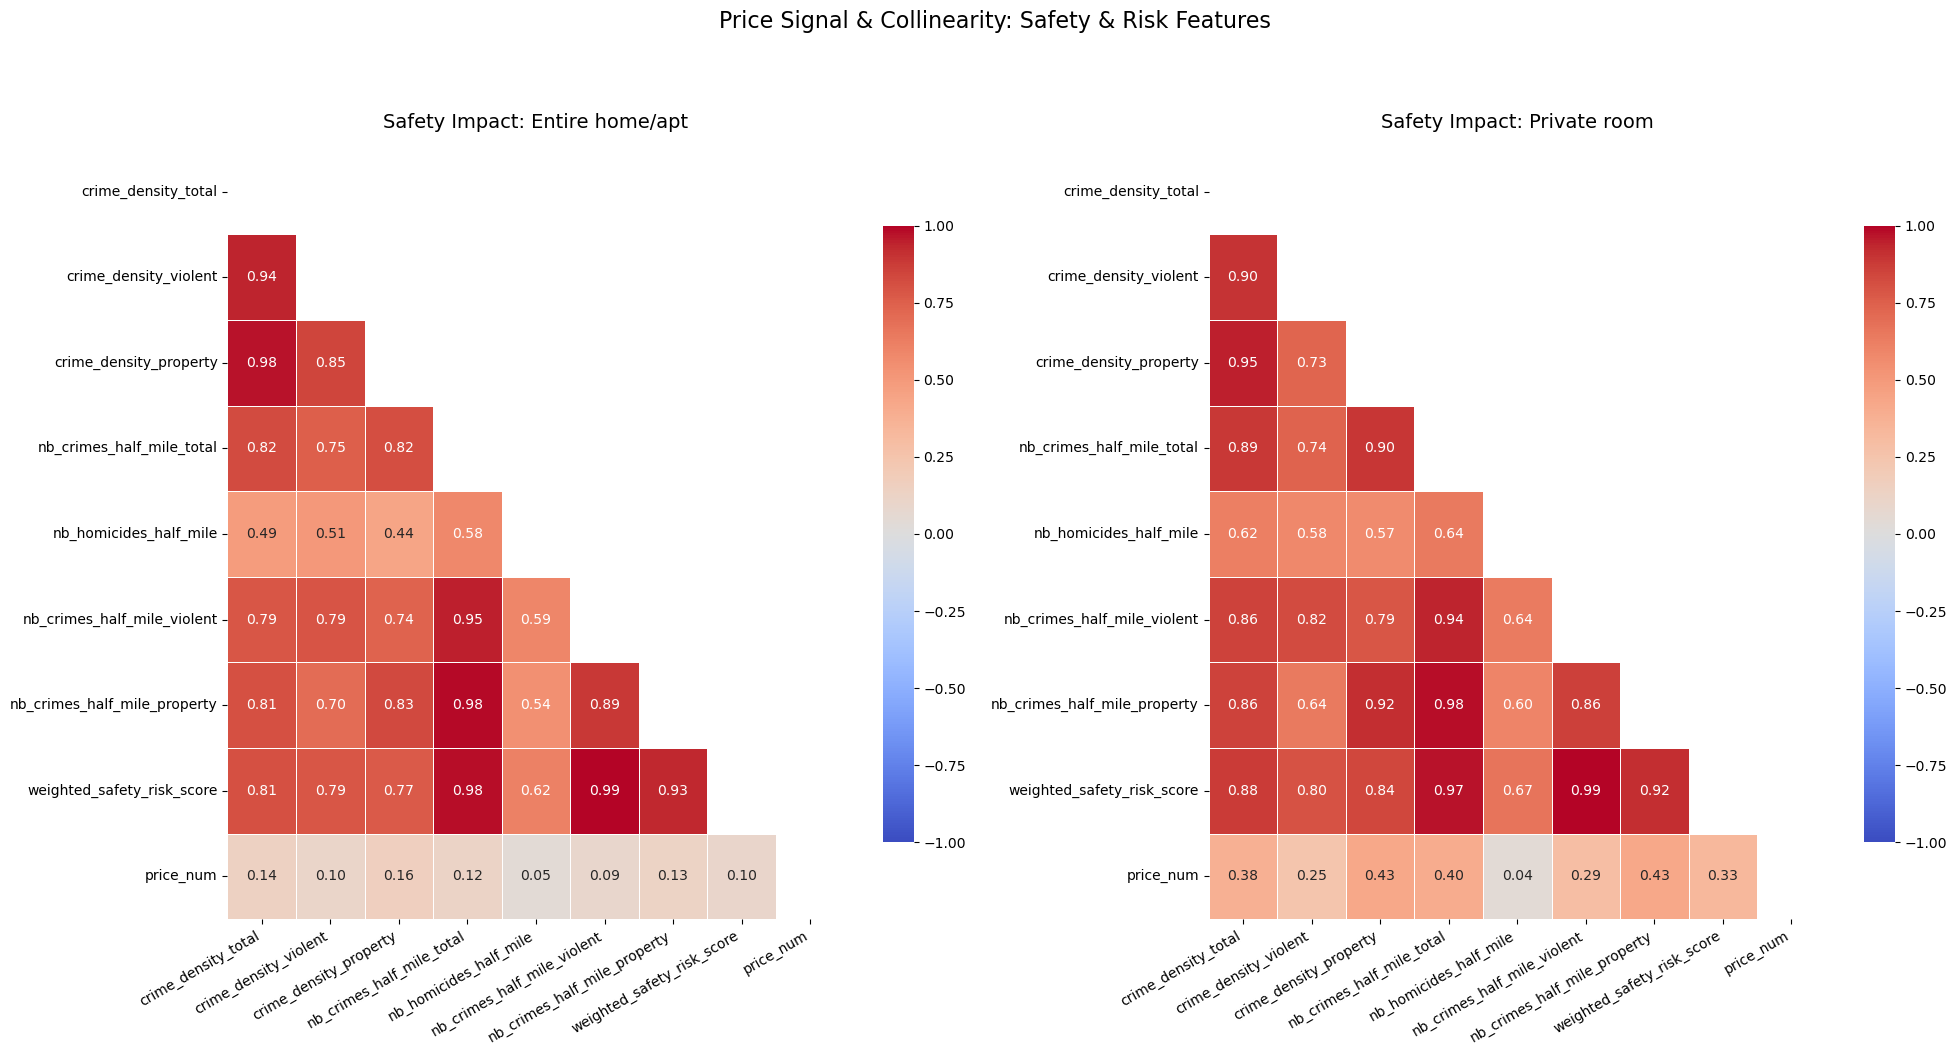

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Define the Safety Matrix features for analysis
# We include densities, buffer counts, and our custom weighted risk score
safety_features = [
    'crime_density_total','crime_density_violent', 'crime_density_property',
    'nb_crimes_half_mile_total','nb_homicides_half_mile', 'nb_crimes_half_mile_violent', 
    'nb_crimes_half_mile_property', 'weighted_safety_risk_score',
    'price_num'
]

room_types = ['Entire home/apt', 'Private room']

print("--- Heatmap: Safety Matrix vs. Price ---")

# 2. Create side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the Pearson correlation matrix
    corr_matrix = subset[safety_features].corr()
    
    # Create a mask to hide the upper triangle for better clarity
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap using 'coolwarm' for consistency with previous modules
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          # Show exact correlation values
        cmap='coolwarm',     # Red for positive, Blue for negative (matches Module 2)
        fmt=".2f",           # 2 decimal places
        vmin=-1, vmax=1,     # Standardized correlation scale
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Safety Impact: {r_type}", fontsize=14, pad=15)
    
    # Rotate x-axis labels to prevent overlap
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')

plt.suptitle("Price Signal & Collinearity: Safety & Risk Features", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

#### 3.3 Final Feature Convergence: Geographic & Safety Integration
To conclude our engineering phase, we perform a strategic pruning of our features. In both the **Lakefront** and **Safety** categories, we observe significant multicollinearity. By retaining only the non-linear gravity scores and specific high-impact risk indicators, we ensure our dataset is optimized for predictive modeling without the noise of redundant distance metrics.

**Trial & Error Note:** 1. **Lakefront Consolidation:** We prioritize `shoreline_gravity` over linear distance as it better reflects the exponential value of a lake view. 
2. **Safety Parsimony:** For crime, we retain `crime_density_total` to represent the general neighborhood reputation and `nb_homicides_half_mile` to capture the most severe localized safety shocks. 
This balanced selection provides a high-fidelity spatial profile of each listing while maintaining statistical stability.

In [80]:
# 1. Finalize Feature Selection: Drop redundant Lakefront & Safety columns
print("--- Executing Final Multi-Scale Feature Selection ---")

# Define all columns to be pruned due to multicollinearity
cols_to_drop = [
    # Lakefront Redundancies
    'dist_to_shoreline_miles', 
    'shoreline_north_premium',
    # Safety Redundancies
    'crime_density_violent', 
    'crime_density_property', 
    'nb_crimes_half_mile_total', 
    'nb_crimes_half_mile_violent', 
    'nb_crimes_half_mile_property', 
    'weighted_safety_risk_score'
]

# Execute dropping with check
existing_drops = [c for c in cols_to_drop if c in listings_cleaned.columns]
listings_cleaned = listings_cleaned.drop(columns=existing_drops)

# 2. Validation and Final Dataset Audit
print(f"🧹 Successfully pruned {len(existing_drops)} redundant features across Geo and Safety domains.")
print("✅ Final feature set retained for analysis.")

# 3. Final Audit of all engineered features currently in the dataset
final_feature_summary = [
    'dist_navy_pier_miles', 
    'is_landmark_proximate', 
    'transit_north_premium', 
    'is_premium_transit_hub',
    'shoreline_gravity',
    'dist_to_nearest_beach_miles',
    'crime_density_total',
    'nb_homicides_half_mile'
]

print("\n--- Final Engineered Feature Set ---")
display(listings_cleaned[final_feature_summary].head())

--- Executing Final Multi-Scale Feature Selection ---
🧹 Successfully pruned 6 redundant features across Geo and Safety domains.
✅ Final feature set retained for analysis.

--- Final Engineered Feature Set ---


,dist_navy_pier_miles,is_landmark_proximate,transit_north_premium,is_premium_transit_hub,shoreline_gravity,dist_to_nearest_beach_miles,crime_density_total,nb_homicides_half_mile
0,7.216880,0,0.044988,0.369664,0.599180,0.527095,390.621248,0
1,3.953885,0,0.136466,0.000000,0.258915,2.979193,314.050512,0
2,2.287453,0,0.214080,0.703779,0.597642,0.818234,253.478374,0
3,3.188397,0,0.175496,0.735046,0.505079,1.427011,253.478374,0
4,4.335197,0,0.136085,0.726042,0.282016,2.870674,258.284525,0


#### 3.4 Unified Correlation Analysis: The Geo-Safety Matrix
This final visualization serves as the "audit trail" for our entire feature engineering process. By plotting all remaining curated features against `price_num`, we can observe the collective impact of location, transit, and safety. 

**Trial & Error Note:** Having pruned the redundant variables in the previous step, this matrix should now be much "cleaner." We are looking for two things:
1. **The Price Signal:** Which features (e.g., `shoreline_gravity` or `transit_north_premium`) exhibit the strongest and most consistent relationship with price across room types?
2. **Residual Collinearity:** While we've dropped the most obvious culprits, some natural spatial correlations will remain (e.g., landmarks are often near transit). This heatmap confirms that these relationships are now at a manageable level for any future modeling or interpretation.

--- Final Unified Heatmap: All Engineered Features vs. Price ---


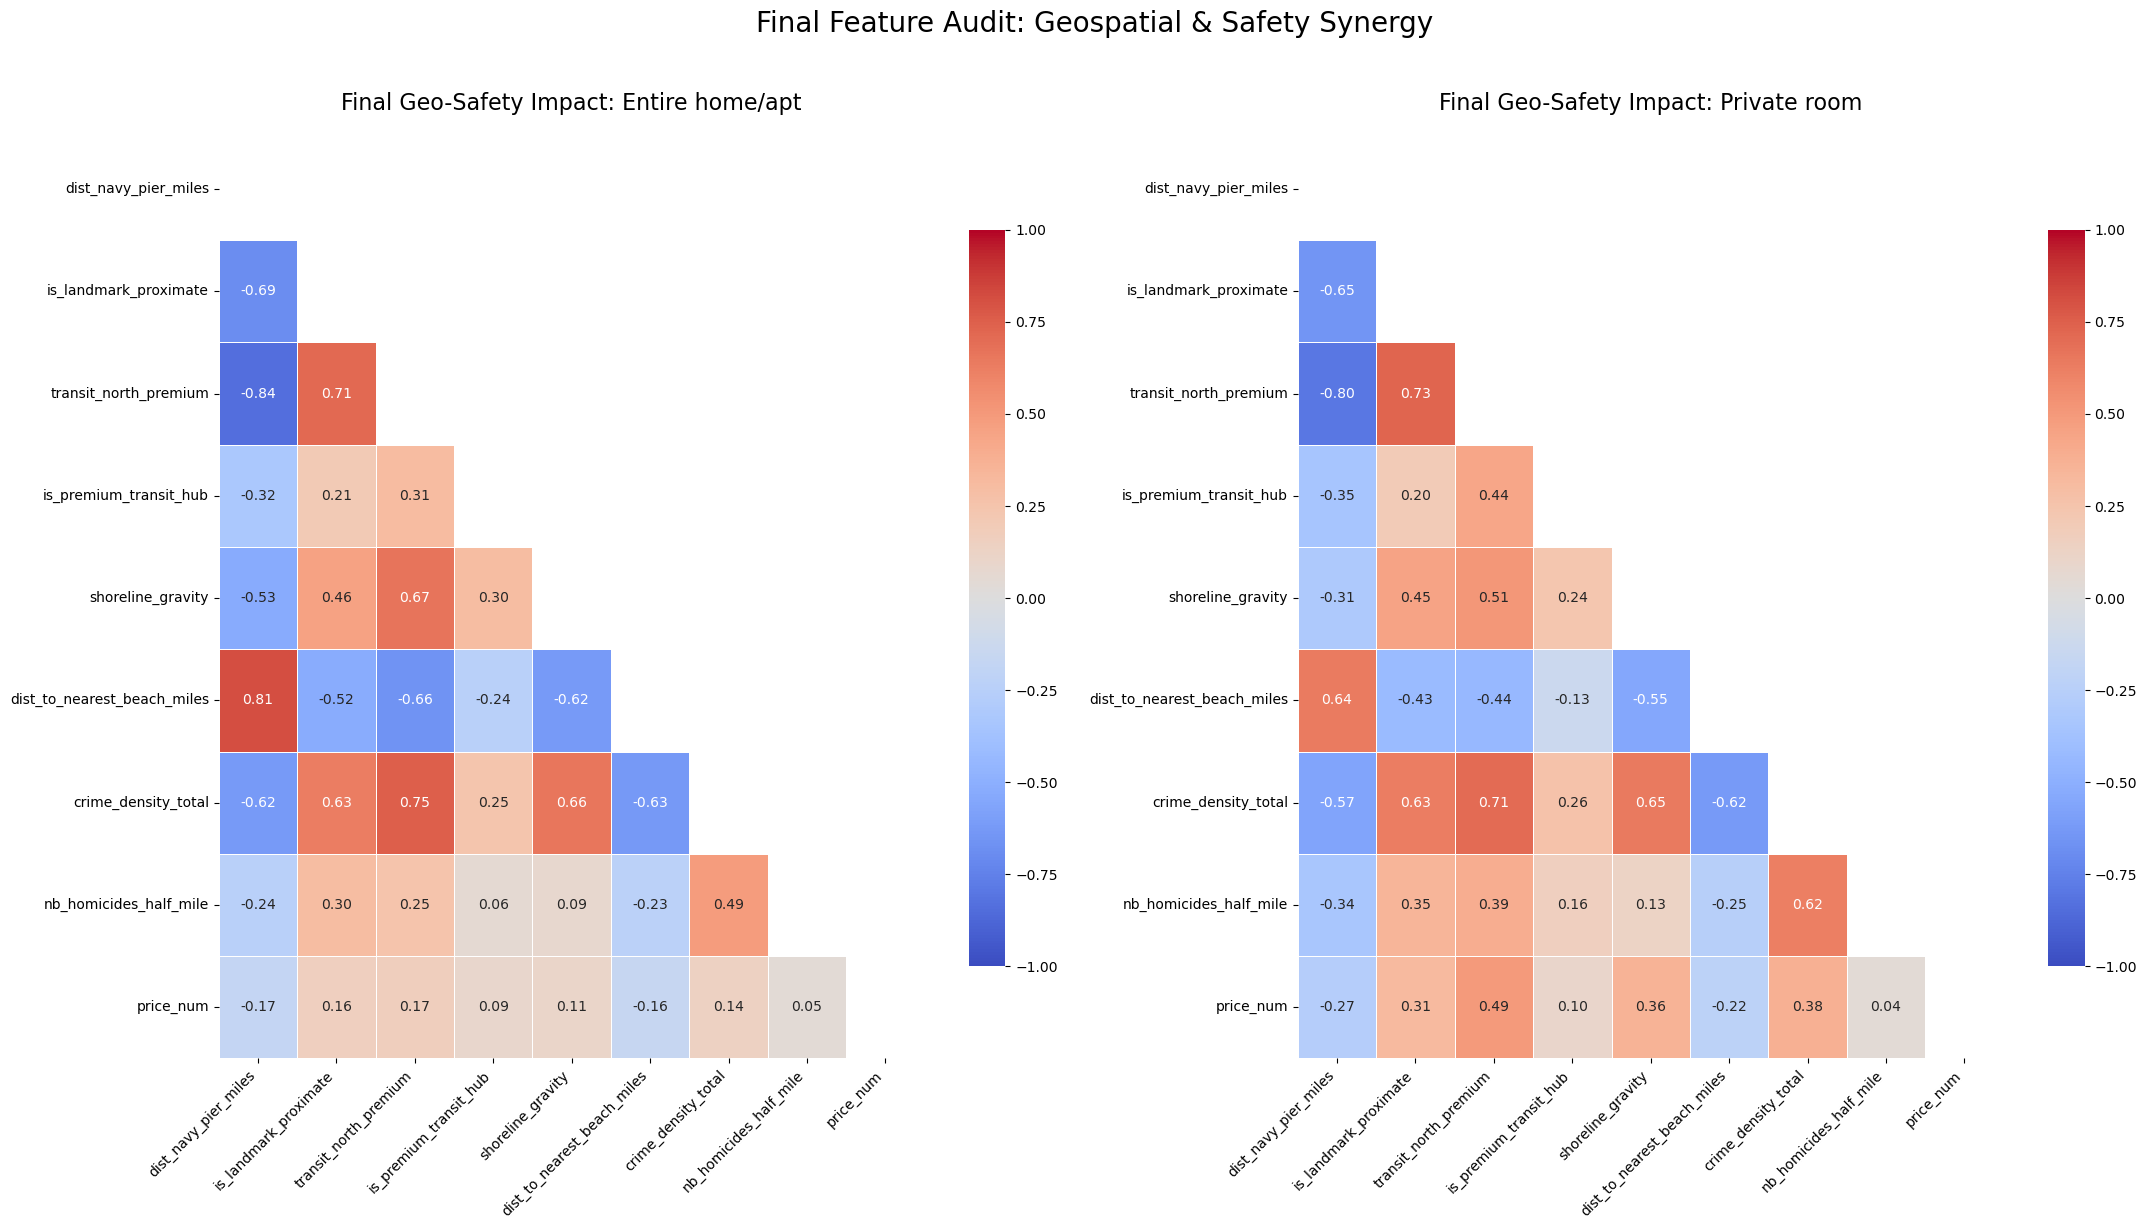

In [81]:
# 1. Define the final curated feature set for analysis
final_analysis_features = [
    'dist_navy_pier_miles', 
    'is_landmark_proximate', 
    'transit_north_premium', 
    'is_premium_transit_hub',
    'shoreline_gravity',
    'dist_to_nearest_beach_miles',
    'crime_density_total',
    'nb_homicides_half_mile',
    'price_num'
]

room_types = ['Entire home/apt', 'Private room']

print("--- Final Unified Heatmap: All Engineered Features vs. Price ---")

# 2. Create side-by-side correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 12))

for i, r_type in enumerate(room_types):
    # Filter dataset by room type
    subset = listings_cleaned[listings_cleaned['room_type'] == r_type]
    
    # Calculate the Pearson correlation matrix
    corr_matrix = subset[final_analysis_features].corr()
    
    # Create a mask to hide the upper triangle for maximum scannability
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Plot heatmap with 'coolwarm' for consistent branding
    sns.heatmap(
        corr_matrix, 
        mask=mask,
        annot=True,          # Show coefficients
        cmap='coolwarm',     # Red (+) / Blue (-)
        fmt=".2f",           # 2 decimal places
        vmin=-1, vmax=1,     # Fixed scale
        linewidths=0.5, 
        ax=axes[i],
        cbar_kws={"shrink": 0.8}
    )
    
    axes[i].set_title(f"Final Geo-Safety Impact: {r_type}", fontsize=16, pad=20)
    
    # Optimize label rotation
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right', fontsize=10)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=10)

plt.suptitle("Final Feature Audit: Geospatial & Safety Synergy", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

### Data Dictionary: Final Geospatial & Safety Feature Set

| Feature Name | Type | Description & Economic Rationale |
| :--- | :--- | :--- |
| **dist_navy_pier_miles** | Numeric | Straight-line distance to Navy Pier. Acts as a proxy for the listing's proximity to Chicago's primary tourism epicenter. |
| **is_landmark_proximate** | Binary | Indicates if a listing is within a critical buffer zone of major Chicago landmarks. Captures the "prestige premium" beyond simple distance. |
| **transit_north_premium** | Numeric | An interaction term capturing the high-value synergy of being near transit specifically in the affluent North Side. Represents the "convenience-location" price boost. |
| **is_premium_transit_hub** | Binary | Flags listings located near major transit nodes (e.g., Union Station or key 'L' junctions). Captures utility for business travelers and commuters. |
| **shoreline_gravity** | Numeric | A non-linear "pull" score for Lake Michigan. Values decay exponentially as distance from the shore increases, modeling the high concentration of value at the waterfront. |
| **dist_to_nearest_beach_miles** | Numeric | Distance to the nearest public beach access. Distinguishes purely aesthetic lake views from actual recreational utility and summer seasonal value. |
| **crime_density_total** | Numeric | Total crime incidents per square mile at the neighborhood level. Represents the "general reputation" and environmental atmosphere of the area. |
| **nb_homicides_half_mile** | Numeric | Count of homicides within a 0.5-mile radius. Serves as a high-impact safety signal; used as a primary "price depressor" to capture extreme risk sensitivity. |
| **price_num** | Numeric | The target variable: Nightly listing price in USD. Cleaned and converted to numeric format for analysis. |

---

### Modeling Note: Feature Parsimony
This feature set has been intentionally pruned to resolve high multicollinearity (VIF reduction). 
- We prioritize **shoreline_gravity** over raw linear distance to better capture non-linear price appreciation.
- We utilize **crime_density_total** to summarize neighborhood-wide trends while using **nb_homicides_half_mile** to capture localized, high-severity psychological deterrents.

In [82]:
import os

# 1. Define the final columns for export
# Switching 'price_num' back to original 'price'
export_columns = [
    'id', 
    'price',
    'dist_navy_pier_miles', 
    'is_landmark_proximate', 
    'transit_north_premium', 
    'is_premium_transit_hub',
    'shoreline_gravity', 
    'dist_to_nearest_beach_miles',
    'crime_density_total', 
    'nb_homicides_half_mile'
]

# 2. Rounding: Ensure all numeric features are capped at 2 decimal places
# We only target the float columns to maintain 'id' and binary flags as integers
float_features = [
    'dist_navy_pier_miles', 
    'transit_north_premium', 
    'is_premium_transit_hub',
    'shoreline_gravity', 
    'dist_to_nearest_beach_miles',
    'crime_density_total'
]

# Apply rounding to the dataframe
listings_cleaned[float_features] = listings_cleaned[float_features].round(4)

# 3. Define output path
output_path = "../../data_processed/Geospatial_Engineering_v3.csv"

print(f"--- Exporting Refined Feature Set to {output_path} ---")

# Ensure the directory exists
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 4. Save to CSV
try:
    # Exporting the selected subset with 2-decimal precision
    listings_cleaned[export_columns].to_csv(output_path, index=False)
    print(f"💾 Successfully saved {len(listings_cleaned)} rows.")
    print(f"✅ Data exported with 2-decimal precision and original 'price' column.")
except Exception as e:
    print(f"❌ Error during export: {e}")

# Final verification of the rounded output
display(listings_cleaned[export_columns].head())

--- Exporting Refined Feature Set to ../../data_processed/Geospatial_Engineering_v3.csv ---
💾 Successfully saved 8663 rows.
✅ Data exported with 2-decimal precision and original 'price' column.


,id,price,dist_navy_pier_miles,is_landmark_proximate,transit_north_premium,is_premium_transit_hub,shoreline_gravity,dist_to_nearest_beach_miles,crime_density_total,nb_homicides_half_mile
0,2384,119.0,7.2169,0,0.0450,0.3697,0.5992,0.5271,390.6212,0
1,7126,89.0,3.9539,0,0.1365,0.0000,0.2589,2.9792,314.0505,0
2,10945,203.0,2.2875,0,0.2141,0.7038,0.5976,0.8182,253.4784,0
3,12140,339.0,3.1884,0,0.1755,0.7350,0.5051,1.4270,253.4784,0
4,28749,258.0,4.3352,0,0.1361,0.7260,0.2820,2.8707,258.2845,0
